In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/My Drive/python_modules')
sys.path.insert(1,'/content/drive/My Drive/data_files')

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
from GradientDescent import GradientDescent

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Helper Class

In [5]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from scipy.stats import shapiro
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class EDA:
    # numeric data types
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    def __init__(self, train_data, test_data, target, skip=None, null_threshold=.6, dup_threshold=.8, corr_threshold=.7, alpha=.05):
        self.train_data = train_data
        self.test_data = test_data
        self.null_threshold = null_threshold
        self.dup_threshold = dup_threshold
        self.corr_threshold = corr_threshold
        self.alpha = alpha
        self.target = target
        self.skip = skip

    # grab numerical data
    def grabNumeric(self, target=True, skip=True):
        numCols = list(set(self.train_data.select_dtypes(include=self.numerics).columns) - set(["Id"]))
        if target == False:
            numCols.remove(self.target)
        if self.skip is not None and skip == True:
            numCols = list(set(numCols) - set(self.skip))
        return numCols

    # grab categorical data
    def grabCategorical(self):
        return list(set(self.train_data.select_dtypes(include=['object']).columns))

    def visualize(self, plot=None):

        # distribution plot
        if plot == 'dist' or plot is None:
            numCols = self.grabNumeric()
            nR = len(numCols) // 4 if len(numCols) % 4 == 0 else len(numCols) // 4 +1
            fig, axes = plt.subplots(nrows=nR, ncols=4, figsize=(20, nR*6))
            i = 0
            j = 0
            for c in numCols:
                if nR == 1:
                    sns.histplot(x=self.train_data[c], ax=axes[i])
                    i += 1
                else:
                    sns.histplot(x=self.train_data[c], ax=axes[i, j])
                    if j < 3:
                        j +=1
                    else:
                        i += 1
                        j = 0

            fig.suptitle('Distribution of numerical features', fontsize=24, color='darkred')
            fig.tight_layout()
            fig.subplots_adjust(top=0.95)

        # boxplot numerical data
        if plot == 'boxplot' or plot is None:
            numCols = self.grabNumeric()
            nR = len(numCols) // 4 if len(numCols) % 4 == 0 else len(numCols) // 4 +1
            fig, axes = plt.subplots(nrows=nR, ncols=4, figsize=(20, nR*6))
            i = 0
            j = 0
            for c in numCols:
                if nR == 1:
                    sns.boxplot(x=self.train_data[c], orient='h', ax=axes[i])
                    i += 1
                else:
                    sns.boxplot(x=self.train_data[c], orient='h', ax=axes[i, j])
                    if j < 3:
                        j +=1
                    else:
                        i += 1
                        j = 0

            fig.suptitle('Boxplot of numerical features', fontsize=24, color='darkred')
            fig.tight_layout()
            fig.subplots_adjust(top=0.95)
            

        # count plot categorical data
        if plot == 'countplot' or plot is None:
            catCols = self.grabCategorical()
            skipped = []
            if len(catCols) > 0:
                nR = len(catCols) // 4 if len(catCols) % 4 == 0 else len(catCols) // 4 + 1
                fig, axes = plt.subplots(nrows=nR, ncols=4, figsize=(20, nR*6))
                i = 0
                j = 0
                for c in catCols:
                    x = self.train_data[c].value_counts().index
                    y = self.train_data[c].value_counts().values
                    if len(x) > 100:
                        skipped.append(c)
                        continue

                    if nR == 1:
                        sns.barplot(x=x, y=y, data=self.train_data, ax=axes[i])
                        i += 1
                    else:
                        sns.barplot(x=x, y=y, data=self.train_data, ax=axes[i, j])
                        if j < 3:
                            j +=1
                        else:
                            i += 1
                            j = 0
            print("Skipped cols in count plot due to values > 100: \n", skipped)
            fig.suptitle('Countplot of categorical features', fontsize=24, color='darkred')
            fig.tight_layout()
            fig.subplots_adjust(top=0.95)

        # correlation heatmap
        if plot == 'corr' or plot is None:
            CM = self.train_data[self.grabNumeric()].corr()
            CM[(CM < 0.3) & (CM > -0.3)] = 0
            UCM = np.triu(np.ones_like(CM, dtype=bool))
            fig = plt.figure(figsize=(20, 15))
            ax = fig.add_subplot()
            sns.heatmap(data=CM, mask=UCM, ax=ax, annot=True)
            fig.suptitle('Correlation heat map of numerical features', fontsize=24, color='darkred')
            fig.tight_layout()
            fig.subplots_adjust(top=0.95)

    # define nulls
    def grabNulls(self, threshold=None):
        if threshold is not None:
            self.null_threshold = threshold
        m = self.train_data.shape[0]
        null_df = self.train_data.isna().sum().reset_index().rename(columns={0: "Null Count"}).sort_values(by=['Null Count'], ascending=False)
        null_df = null_df[null_df["Null Count"] > 0]
        # columns to be dropped > null_threshold
        CTBD = null_df[null_df['Null Count']/m >= self.null_threshold]
        # rows to be dropped < .1 of samples
        RTBD = null_df[null_df['Null Count']/m <= .1]
        # Records to be filled
        RTBF = null_df[((null_df['Null Count']/m <= self.null_threshold)
                      & (null_df['Null Count']/m > .1))]

        return CTBD, RTBD, RTBF

    def handleNulls(self, threshold=None):
        CTBD, RTBD, RTBF = self.grabNulls(threshold)
        # drop columns with nulls > threshold
        nCols = [s[0] for s in CTBD.values]
        self.train_data = self.train_data.drop(columns=nCols)
        # drop same columns from test data
        if self.test_data is not None:
            self.test_data.drop(columns=nCols, inplace=True)
            self.test_data.dropna(inplace=True)
        # grab cols with rows cotaining nulls in it
        cols = [s[0] for s in RTBD.values]
        # delete records from column with value < .06
        self.train_data = self.train_data.dropna(subset=cols)

        # fill records with mean
        # seperate numeric cols from categorical
        numCols = self.grabNumeric()
        catCols = self.grabCategorical()
        # nurical cols to be filled
        numNull = np.array([])
        # categorical cols to be filled
        catNull = np.array([])
        N = [s[0] for s in RTBF.values]
        for n in N:
            # filter null based on colum type numerical or categorical
            if n in numCols:
                numNull = np.append(numNull, n)
            else:
                catNull = np.append(catNull, n)

        # fill numerical cols with mean
        self.train_data[numNull] = self.train_data[numNull].apply(lambda x: x.fillna(x.mean()))
        # fill categorical cols with mod
        self.train_data[catNull] = self.train_data[catNull].apply(lambda x: x.fillna(x.mode()[0]))

    # duplicated
    def handleDuplicates(self, threshold=None):
        if threshold is not None:
            self.dup_threshold = threshold
        # rows, columns
        m, n = self.train_data.shape
        # list of columns with same value
        dupCol = []
        for c, cData in self.train_data.iteritems():
            # Value counts
            VC = any(cData.value_counts().values/m > self.dup_threshold)
            if VC:
                dupCol.append(c)

        self.train_data.drop(columns=dupCol, inplace=True)
        # drop same columns from test data
        if self.test_data is not None:
            self.test_data.drop(columns=dupCol, inplace=True)
        return dupCol

    # correlated features
    def handleCorrFeature(self, threshold=None):
        if threshold is not None:
            self.corr_threshold = threshold
        numCols = [c for c in self.train_data.columns.tolist() if c in self.grabNumeric()]
        CM = self.train_data[numCols].corr()
        # features to be deleted
        redundantFeatures = []
        # correlation values
        corrValues = []
        for index, i in enumerate(numCols):
            # skip target column in the filtering or other custom table
            if i == self.target or i == self.skip:
                continue
            # loop over the upper triangle matrix of the corr matrix since it is symetric
            for j in numCols[index+1:-1]:
                if j == self.skip or j == self.target:
                    continue
                # correlation between 2 features
                cSample = abs(CM.loc[i][j])

                # check for correlation threshold
                if cSample >= self.corr_threshold:
                    # choose which feature is more correlated to target
                    if abs(CM.loc[i][self.target]) > abs(CM.loc[j][self.target]):
                        redundantFeatures.append(j)

                    else:
                        redundantFeatures.append(i)

                    corrValues.append({
                        "Feature correlation":  CM.loc[i][j],
                        f"Feature {i} vs {self.target}":  CM.loc[i][self.target],
                        f"Feature {j} vs {self.target}":  CM.loc[j][self.target],
                    })


        # drop redundant features
        self.train_data.drop(columns=redundantFeatures, inplace=True)
        # drop same columns from test data
        if self.test_data is not None:
            self.test_data.drop(columns=redundantFeatures, inplace=True)
        return redundantFeatures, corrValues


    def checkOutliers(self, threshold=1.5):
        numCols = [c for c in self.train_data.columns.tolist() if c in self.grabNumeric(target=False)]
        # Q1 = self.train_data[numCols].quantile(.25)
        # Q3 = self.train_data[numCols].quantile(.75)
        # IQR = Q3 - Q1
        # lower = Q1 - threshold * IQR
        # upper = Q3 + threshold * IQR
        # lt_lower = self.train_data.index[self.train_data[numCols] < lower]
        # gt_upper = self.train_data.index[self.train_data[numCols] > lower]
        # bounds = np.c_[lower, lt_lower.sum(), upper, gt_upper.sum()]
        # outlier_df = pd.DataFrame(data=bounds, index=numCols, columns=['Lower Bound', 'Below Lower Count', 'Upper Bound', 'Above Upper Count'])
        # return outlier_df
        # dict to hold outliers
        outliers = {}
        for c in self.train_data[numCols]:
            Q1 = self.train_data[c].quantile(.25)
            Q3 = self.train_data[c].quantile(.75)
            IQR = Q3 - Q1
            lower = Q1 - threshold * IQR
            upper = Q3 + threshold * IQR
            # grab rows < lower bound
            LO = self.train_data.index[self.train_data[c] < lower].tolist()
            # grab rows > upper bound
            UO = self.train_data.index[self.train_data[c] > upper].tolist()

            outliers[c] = {
                "Lower Bound": lower,
                "Below Lower": LO,
                "Upper Bound": upper,
                "Above Upper": UO
            }

        return outliers

    # box plot outliers
    def boxplotOutliers(self):
        outliers = list(self.checkOutliers().keys())
        j = 0
        nC = 6
        nR = len(outliers) // nC if len(outliers) % nC == 0 else (len(outliers) // nC) + 1
        if nR == 1:
            fig, axes = plt.subplots(nrows=nR, figsize=(20, 10))
            sns.boxplot(data=self.train_data[outliers])

        else:
            fig, axes = plt.subplots(nrows=nR, figsize=(30, 30))
            for i in range(0, len(outliers), nC):
                sns.boxplot(data=self.train_data[outliers[i:i+nC]], ax=axes[j])
                j += 1


    # hand outliers
    def handleOutliers(self):
        # grab the outliers
        outliers = self.checkOutliers()

        for c in outliers:
            # grab col
            col = outliers[c]
            # if there are values below lower bound
            if len(col['Below Lower']) > 0:
                # replace them with the lower bound
                self.train_data.loc[col['Below Lower'], c] = col['Lower Bound']
            # if there are values above upper bound
            if len(col['Above Upper']) > 0:
                # replace with the upper bound
                self.train_data.loc[col['Above Upper'], c] = col['Upper Bound']

    # check skewness
    def calcSkew(self, target):
        n = self.train_data.shape[0]
        numCols = self.grabNumeric(target=target)
        mu = self.train_data[numCols].mean()
        std = self.train_data[numCols].std()
        skw = pd.DataFrame(np.sum(np.power((self.train_data[numCols] - mu), 3)) / ((n - 1) * np.power(std, 3)) ).rename(columns={0: "Skew Value"})
        return skw

    # log transformation for skewed features
    def handleSkew(self, target=False):
        skw = self.calcSkew(target)
        for s in skw.index.tolist():
            if (skw.loc[s][0] > 1 or skw.loc[s][0] < -1) and skw.loc[s][0] >=0:
                # aplly log transform to column with abs(skewness) > 1 (+, -)
                self.train_data[s] = np.log(1 + abs(self.train_data[s]))
                if self.test_data is not None:
                    self.test_data[s] = np.log(1 + abs(self.test_data[s]))

    # check for normal distributed features
    # draw QQ plot
    def drawQQ(self):
        numCols = self.grabNumeric()
        if self.target in numCols:
            numCols.remove(self.target)
        nC = 4
        nR = len(numCols) // 4 if len(numCols) % 4 == 0 else (len(numCols) // 4) + 1
        if nR == 1:
            fig, axes = plt.subplots(nrows=nR, ncols=len(numCols), figsize=(20, 10))
        else:
            fig, axes = plt.subplots(nrows=nR, ncols=nC, figsize=(20, nR*15))

        i=0
        j=0
        for col in numCols:
            if nR == 1:
                sm.qqplot(self.train_data[col],fit = False, line='q', ax = axes[j])
                axes[j].set_title(col)
                if(j<nC-1):
                    j+=1
                else:
                    i+=1
                    j=0
            else:
                sm.qqplot(self.train_data[col],fit = False, line='q', ax = axes[i, j])
                axes[i, j].set_title(col)
                if(j<nC-1):
                    j+=1
                else:
                    i+=1
                    j=0
        plt.show();

    # shapiro method
    def checkDistribution(self, threshold=None, target=True, skip=True):
        if threshold is not None:
            self.alpha = threshold
        numCols = self.grabNumeric(target=target, skip=skip)

        # list for gaussianFeatures
        gaussianFeatures = []
        # list for nonGaussianFeatures
        nonGaussianFeatures = []
        for c in numCols:
            # calc w and p Statistics for each column
            w_stat, p = shapiro(self.train_data[c].sample(n=500, replace=False))
            print('W_Statistic=%.3f, p=%.8f' % (w_stat, p))

            # if p > alpha add to gaussianFeatures
            if p >= self.alpha:
                print(f'{c} looks like gaussian (fail to reject H0)')
                gaussianFeatures.append(c)

            # if p < alpha add to nongaussianFeatures
            else:
                print(f'{c} does not look Gaussian (reject H0)')
                nonGaussianFeatures.append(c)

        return gaussianFeatures, nonGaussianFeatures


    # scale features
    def featureScale(self):
        gFeatures, nonGFeatures = self.checkDistribution()
        # std scale gausian features
        if len(gFeatures) > 0:
            stdScaler = StandardScaler()
            stdScaler = stdScaler.fit(self.train_data[gFeatures])
            self.train_data[gFeatures] = stdScaler.transform(self.train_data[gFeatures])
            if self.test_data is not None:
                self.test_data[gFeatures] = stdScaler.transform(self.test_data[gFeatures])

        # minmax scale non gausian features
        if len(nonGFeatures) > 0:
            mmScaler = MinMaxScaler()
            mmScaler = mmScaler.fit(self.train_data[nonGFeatures])
            self.train_data[nonGFeatures] = mmScaler.transform(self.train_data[nonGFeatures])
            if self.test_data is not None:
                self.test_data[nonGFeatures] = mmScaler.transform(self.test_data[nonGFeatures])

    #split data
    def trainTestSplit(self, test_size, random_state, include=None, exclude=None):
        if include is None and exclude is None:
            numCols = self.grabNumeric(target=False)

        elif include is not None:
            numCols = include

        elif exclude is not None:
            numCols = self.grabNumeric(target=False)
            if exclude in numCols:
                numCols.remove(exclude)
        else:
            numCols = self.grabNumeric(target=False)

        if self.test_data is not None:
            xTrain = self.train_data[numCols]
            yTrain = self.train_data[self.target]
            xTest = self.test_data[numCols]
            yTest = self.test_data[self.target]
            # check gausian and non gausian features
            gFeatures, nonGFeatures = self.checkDistribution()

            if len(gFeatures) > 0:
                stdScaler = StandardScaler()
                stdScaler = stdScaler.fit(xTrain[gFeatures])
                xTrain = stdScaler.transform(xTrain[gFeatures])
                xTest = stdScaler.transform(xTest[gFeatures])

            if len(nonGFeatures) > 0:
                mmScaler = MinMaxScaler()
                mmScaler = mmScaler.fit(xTrain[nonGFeatures])
                xTrain = mmScaler.transform(xTrain[nonGFeatures])
                xTest = mmScaler.transform(xTest[nonGFeatures])

        else:
            xTrain, xTest, yTrain, yTest = train_test_split(self.train_data[numCols],
                                                    self.train_data[self.target],
                                                    test_size=test_size, random_state=random_state)

        return xTrain, xTest, yTrain, yTest


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


class GradientDescent:
    def __init__(self, data, alpha=.01, gamma=.9, beta1=.9, beta2=.999, e=1e-8):
        self.data = data
        self.alpha = alpha
        self.gamma = gamma
        self.beta1 = beta1
        self.beta2 = beta2
        self.e = e
        self.stepCount = 1
        self.steps = []


    # h(x) = theta0 + theta1 * x1 ....thetan * xn
    """
    x0 = 1
    |1 x1 x2| |theta0|   |y^0|
    |.......| |theta1| = |y^1|
    |.......| |theta2|   |y^2|
    """
    def hypo(self, x0, x):
        hX = x @ x0
        return hX

    # calculate cost
    """
    cost = sum((predicted - y) ** 2) / 2m
    cost = error.T @ error /2m

    error = (predicted - true)
    |y^1|   |y1|   |e1|
    |y^2| - |y2| = |e2|
    |y^3|   |y3|   |e3|

    2/m * |e1 e2 e3| |e1|
                     |e2| = [cost]
                     |e3|

    """

    def CostFunction(self, hX, y):
        error = (hX - y)
        cost = (error.T @ error) /(2*hX.shape[0])
        return cost


    # calculate partial derivative for each parameter
    """
    gradient = (sum(predicted - y) * x)/m
    error = (predicted - true)
    |y^1|   |y1|   |e1|
    |y^2| - |y2| = |e2|
    |y^3|   |y3|   |e3|

    gradient = X.T * error
    |x0 ......| |e1|   |g0|
    |x1 ......| |e2| = |g1|
    |x2 ......| |e3|   |g2|
    """
    def Gradient(self, hX, Y, X):
        m = X.shape[0]
        error = hX - Y
        return (X.T @ error) / m

    def updateTheta(self, x0, gradient, mT=None, vT=None, opt=None, x=None, y=None, stepCount=None):
        # default step(optimizer)
        if opt is None:
            x0 = x0 - (self.alpha * gradient)
            return x0

        # momentum based step
        elif opt == "mT":
            mT = self.gamma * mT + self.alpha * gradient
            x0 = x0 - mT
            return x0, mT

        # Nestrove accelrated gradient
        elif opt == "NAG":
            # calculate theta temp to look in first
            xTemp = x0 - self.gamma * mT
            # evaluate h(x) at theta temp
            hXTemp = self.hypo(xTemp, x)
            # calculate gradient at theta temp
            xTempGrad = self.Gradient(hXTemp, y, x)
            # update theta based on theta temp
            x0 = xTemp - self.alpha * xTempGrad
            mT = self.gamma * mT + self.alpha * xTempGrad

            return x0, mT

        elif opt == "ADGRAD":
            vT = vT + gradient**2
            x0 = x0 - ((self.alpha / (np.sqrt(vT) + self.e)) * gradient)
            return x0, vT

        elif opt == "RMSP":
            vT = self.gamma * vT + (1 - self.gamma) * gradient**2
            x0 = x0 - ((self.alpha / (np.sqrt(vT) + self.e)) * gradient)
            return x0, vT

        elif opt == "ADAM":
            # mt
            mT = self.beta1 * mT + (1 - self.beta1) * gradient
            # vt
            vT = self.beta2 * vT + (1 - self.beta2) * gradient**2
            # bias correction
            mT_ = mT / (1 - np.power(self.beta1, stepCount))
            vT_ = vT / (1 - np.power(self.beta2, stepCount))

            # update the vector
            x0 = x0 - ((self.alpha / (np.sqrt(vT_) + self.e)) * mT_)
            return x0, vT, mT


    #------------------------------------------------#
    def prepareData(self, opt=None, CF=False):
        # shuffle data
        # np.random.shuffle(self.data)
        # self.data.sample(frac=1)
        # inital theta vector
        n = self.data.shape[1]
        x0 = np.zeros((n, 1))
        # create vector column of ones for theta0
        ones = np.ones_like(self.data[:, [0]])
        # build up matrix from x data and ones vector
        X = np.c_[ones, self.data[:, :-1]]
        # true y value is the last column in the data
        Y = self.data[:, [-1]]

        # return X with ones if solving with normal equation
        if CF == True:
            return X, Y

        # Momentum and Nestrov
        if opt == "mT" or opt == "NAG":
            mT = np.zeros_like(x0)
            return X, Y, x0, mT

        # ADAM
        elif opt == "ADAM":
            vT = np.zeros_like(x0)
            mT = np.zeros_like(x0)
            return X, Y, x0, vT, mT

        # ADGRAD and RMSP
        elif opt == "ADGRAD" or opt == "RMSP":
            vT = np.zeros_like(x0)
            return X, Y, x0, vT


        return X, Y, x0


    def fit(self, size=None, opt=None, epochs=None):
        if epochs is None:
            k = 10000
        else:
            k = epochs
        # batch size equall full data if not given
        if size is None:
            size = self.data.shape[0]

        self.stepCount = 1
        self.steps.clear()
        oldCost = None

        # grab the data
        if opt == "mT" or opt == "NAG":
            X, Y, x0, mT = self.prepareData(opt="mT")
        elif opt == "ADGRAD" or opt == "RMSP":
            X, Y, x0, vT = self.prepareData(opt="ADGRAD")
        elif opt == "ADAM":
            X, Y, x0, vT, mT = self.prepareData(opt="ADAM")
        else:
            X, Y, x0 = self.prepareData()

        # number of batches
        nb = self.data.shape[0] // size if self.data.shape[0] % size == 0 else (self.data.shape[0]//size) + 1
        for i in range(0, k):
            bT = 0
            for i in range(0, nb):
                xBatch = X[bT: bT+size, :]
                yBatch = Y[bT: bT+size, :]
                # calculate h(x)
                hX = self.hypo(x0, xBatch)

                # calculate cost
                newCost = self.CostFunction(hX, yBatch)

                # calculate gradient at current x
                gradient = self.Gradient(hX, yBatch, xBatch)
                # update the vector
                if opt == "mT":
                    x0, mT = self.updateTheta(x0, gradient, mT, opt="mT")
                elif opt == "NAG":
                    x0, mT = self.updateTheta(x0, gradient, mT, opt="NAG", x=xBatch, y=yBatch)
                elif opt == "ADGRAD":
                    x0, vT = self.updateTheta(x0, gradient, vT=vT, opt="ADGRAD")
                elif opt == "RMSP":
                    x0, vT = self.updateTheta(x0, gradient, vT=vT, opt="RMSP")
                elif opt == "ADAM":
                    x0, vT, mT = self.updateTheta(x0, gradient, vT=vT, mT=mT, opt="ADAM", stepCount=self.stepCount)
                else:
                    x0 = x0 - (self.alpha * gradient)

                # update step
                self.stepCount +=1

                iterData = {"theta": x0, "cost": newCost, "steps": hX}
                self.steps.append(iterData)

                # update the size
                bT += size

            # break condition "no update in the cost
            if oldCost is not None and abs(newCost - oldCost) <= 1e-5:
                break
            # save the current cost in the oldCost variable
            oldCost = newCost

        if opt is None:
            if size == 1:
                opt = "Stochastic"
            elif size == self.data.shape[0]:
                opt = "Batch GD"
            else:
                opt = "Mini Batch GD"

        plt_hX = self.hypo(x0, X)
        self.plot(opt, size, plt_hX)

    def r2_score(self):
        bf = self.steps[-1]["theta"]
        ones = np.ones((self.data.shape[0], 1))
        M = np.c_[ones, self.data[:, :-1]]
        y_ = M @ bf
        score = r2_score(y_, self.data[:, [-1]])
        return score

    def plot(self, opt, batch, plt_hX):
        x = self.data[:, [0]]
        y = self.data[:, [1]]
        xCost = list(range(len(self.steps)))
        yCost = [s["cost"][0][0] for s in self.steps]
        fig = plt.figure(figsize=(18, 8))


        ax2 = fig.add_subplot(122)
        ax2.plot(xCost, yCost, label="MSE")
        ax2.set_title("MSE vs iterations")
        ax2.set_xlabel("Iteration", fontsize=16).set_color('darkred')
        ax2.set_ylabel("MSE", fontsize=16).set_color('darkred')

        if self.data.shape[1] == 2:
            ax1 = fig.add_subplot(121)
            ax1.scatter(x, y, label="Date point")
            ax1.plot(x, plt_hX, label="Regression Line", color='red')

            ax1.set_xlabel("X", fontsize=16).set_color('darkred')
            ax1.set_ylabel("Y", fontsize=16).set_color('darkred')
            ax1.set_title("Regression Line")
            ax1.grid()
        ax2.grid()
        plt.legend()
        plt.show();
        if opt is None:
            opt = "GD"
        score = self.r2_score()
        print("r2_score: ", score)
        print("Optimizer: ", opt)
        print("Batch size: ", batch)
        print("Total number of iterations: ", self.stepCount - 1)
        print("alpha: ", self.alpha)
        if opt == "ADAM":
            print(f"gamma: {self.gamma} | beta1: {self.beta1} | beta2: {self.beta2}")
        if opt == "RMSP" or opt == "mT" or opt == "NAG":
            print(f"gamma: {self.gamma}")
        print("Optimal thetas values:\n", self.steps[-1]["theta"])

    # normal equation
    def linear_reg_SVD(self, zero_threshold = 1e-13, with_ones=False):
        if with_ones == True:
            X, Y = self.prepareData(CF=True)
        else:
            X, Y = self.data[:, :-1], self.data[:, [-1]]
        u, s, vT = np.linalg.svd(X, full_matrices= False)

        # Now initialize the "pseudo-"inverse of Sigma, where "pseudo" means "don't divide by zero"
        sigma_pseudo_inverse = np.zeros((vT.shape[0], vT.shape[0]))

        # getting the index of the first approximately zero singular value
        zero_sigma_index= np.where(s <= zero_threshold)

        if len(zero_sigma_index[0]) == 0:
            sigma_pseudo_inverse[:,:] = np.diag(1/s[:])
        else:
            zero_sigma_index = zero_sigma_index[0][0]
            # 1/non-zero diagonal elements calculation
            sigma_pseudo_inverse[:zero_sigma_index,:zero_sigma_index] = np.diag(1/s[ :zero_sigma_index])

        # calculating the optimal coefficients
        optimal_coefficients = vT.T.dot(sigma_pseudo_inverse).dot(u.T).dot(Y)
        return optimal_coefficients


# EDA

In [7]:
df = pd.read_csv("/content/drive/MyDrive/data_files/train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Load the data in class object

In [8]:
train_data, test_data = train_test_split(df, test_size=.25, random_state=1)

In [9]:
HP = EDA(train_data=train_data, test_data=test_data, target='SalePrice', null_threshold=.45)

## Visuals

Skipped cols in count plot due to values > 100: 
 []


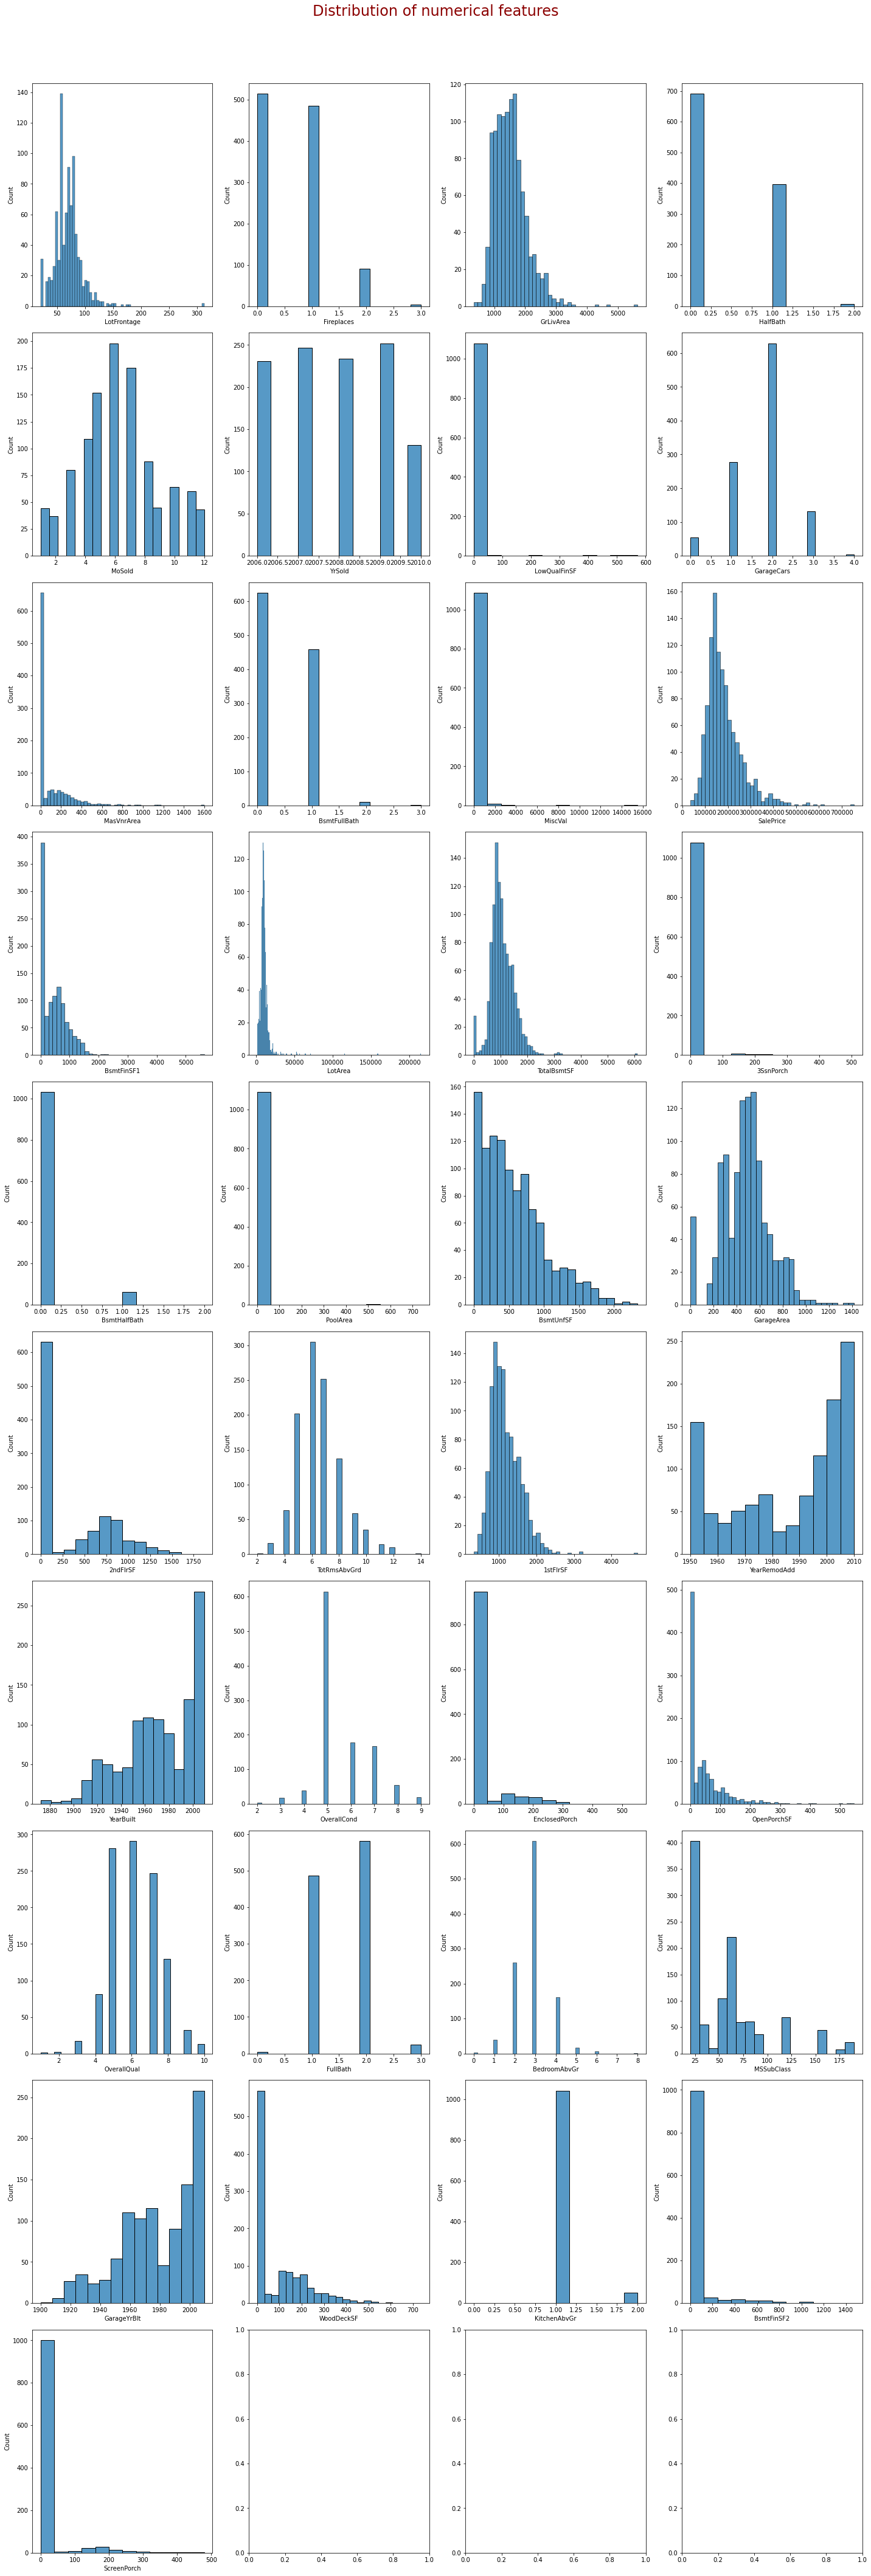

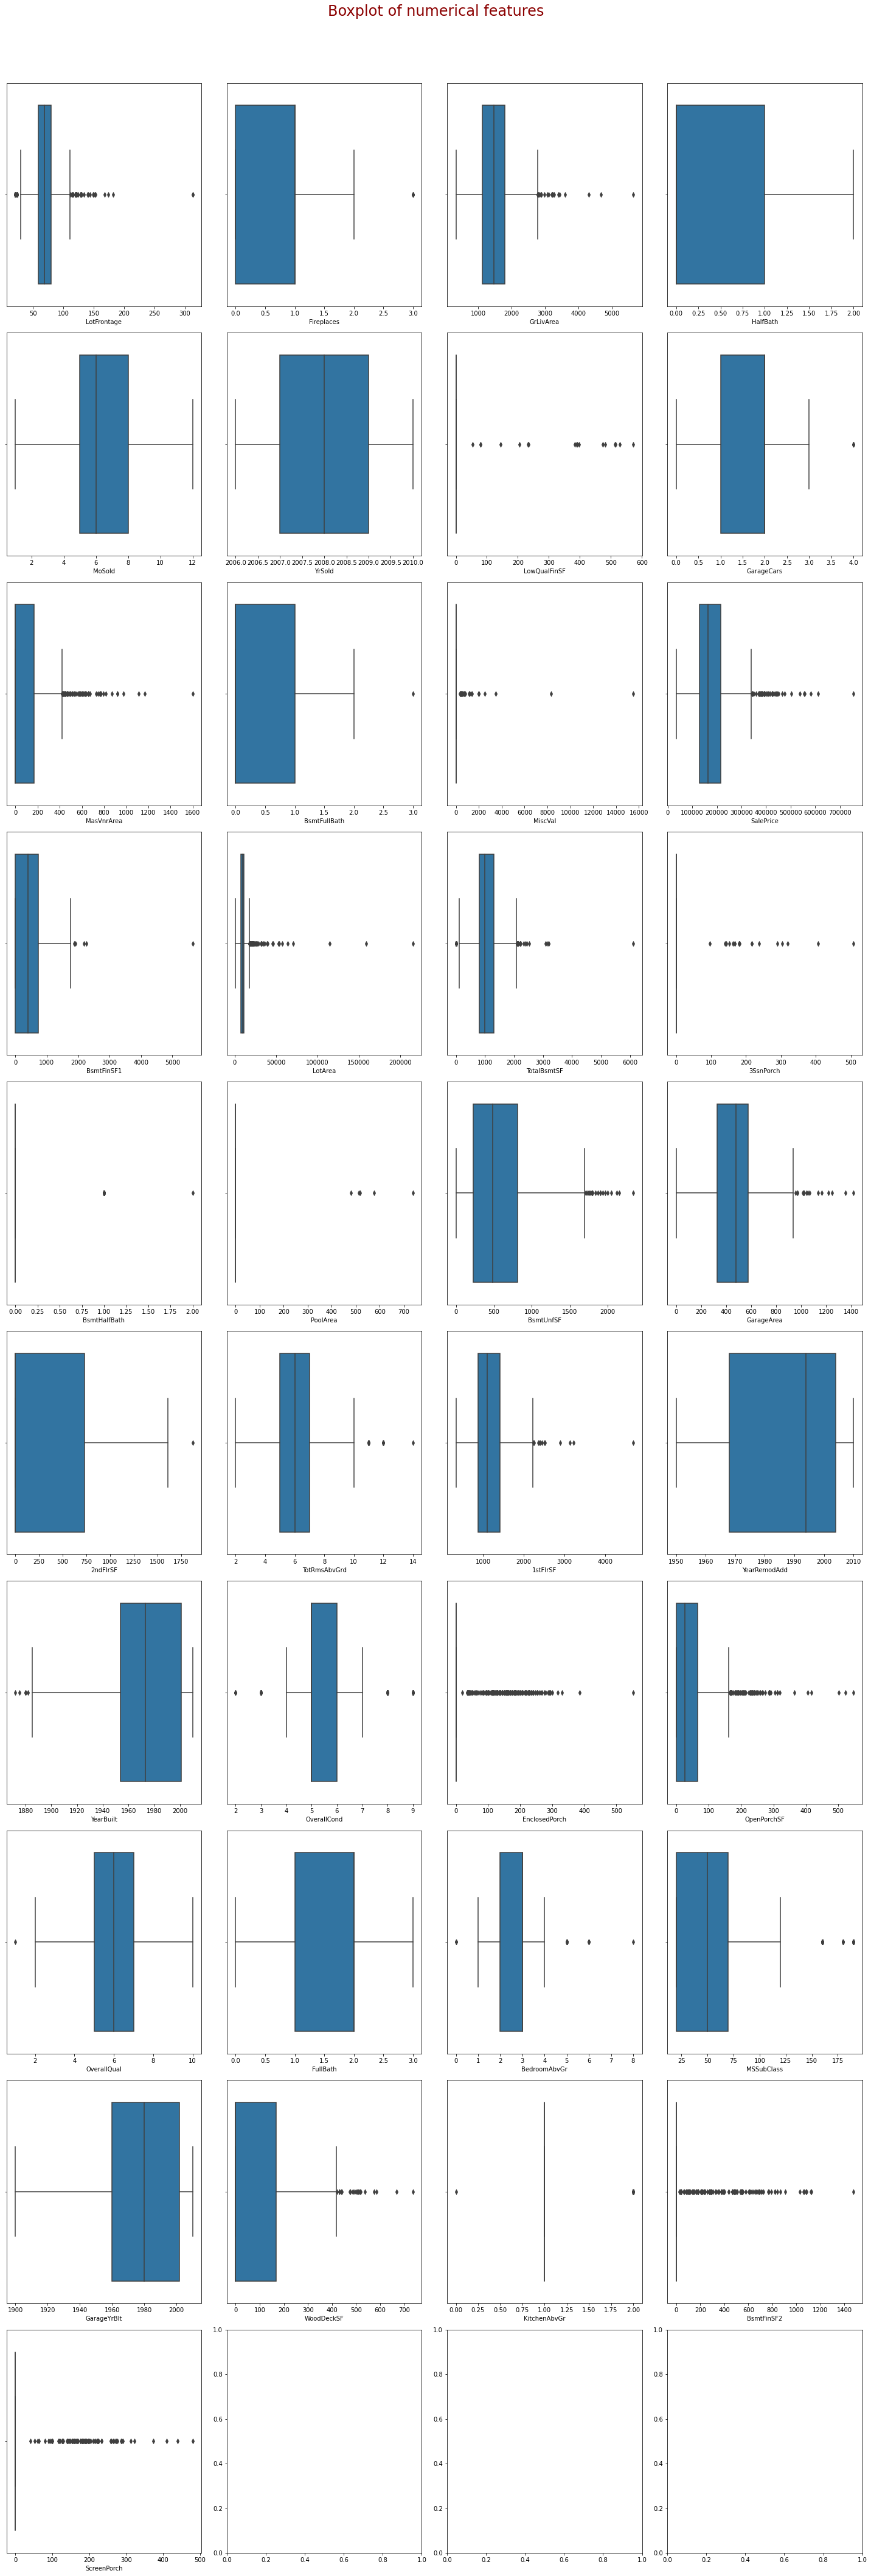

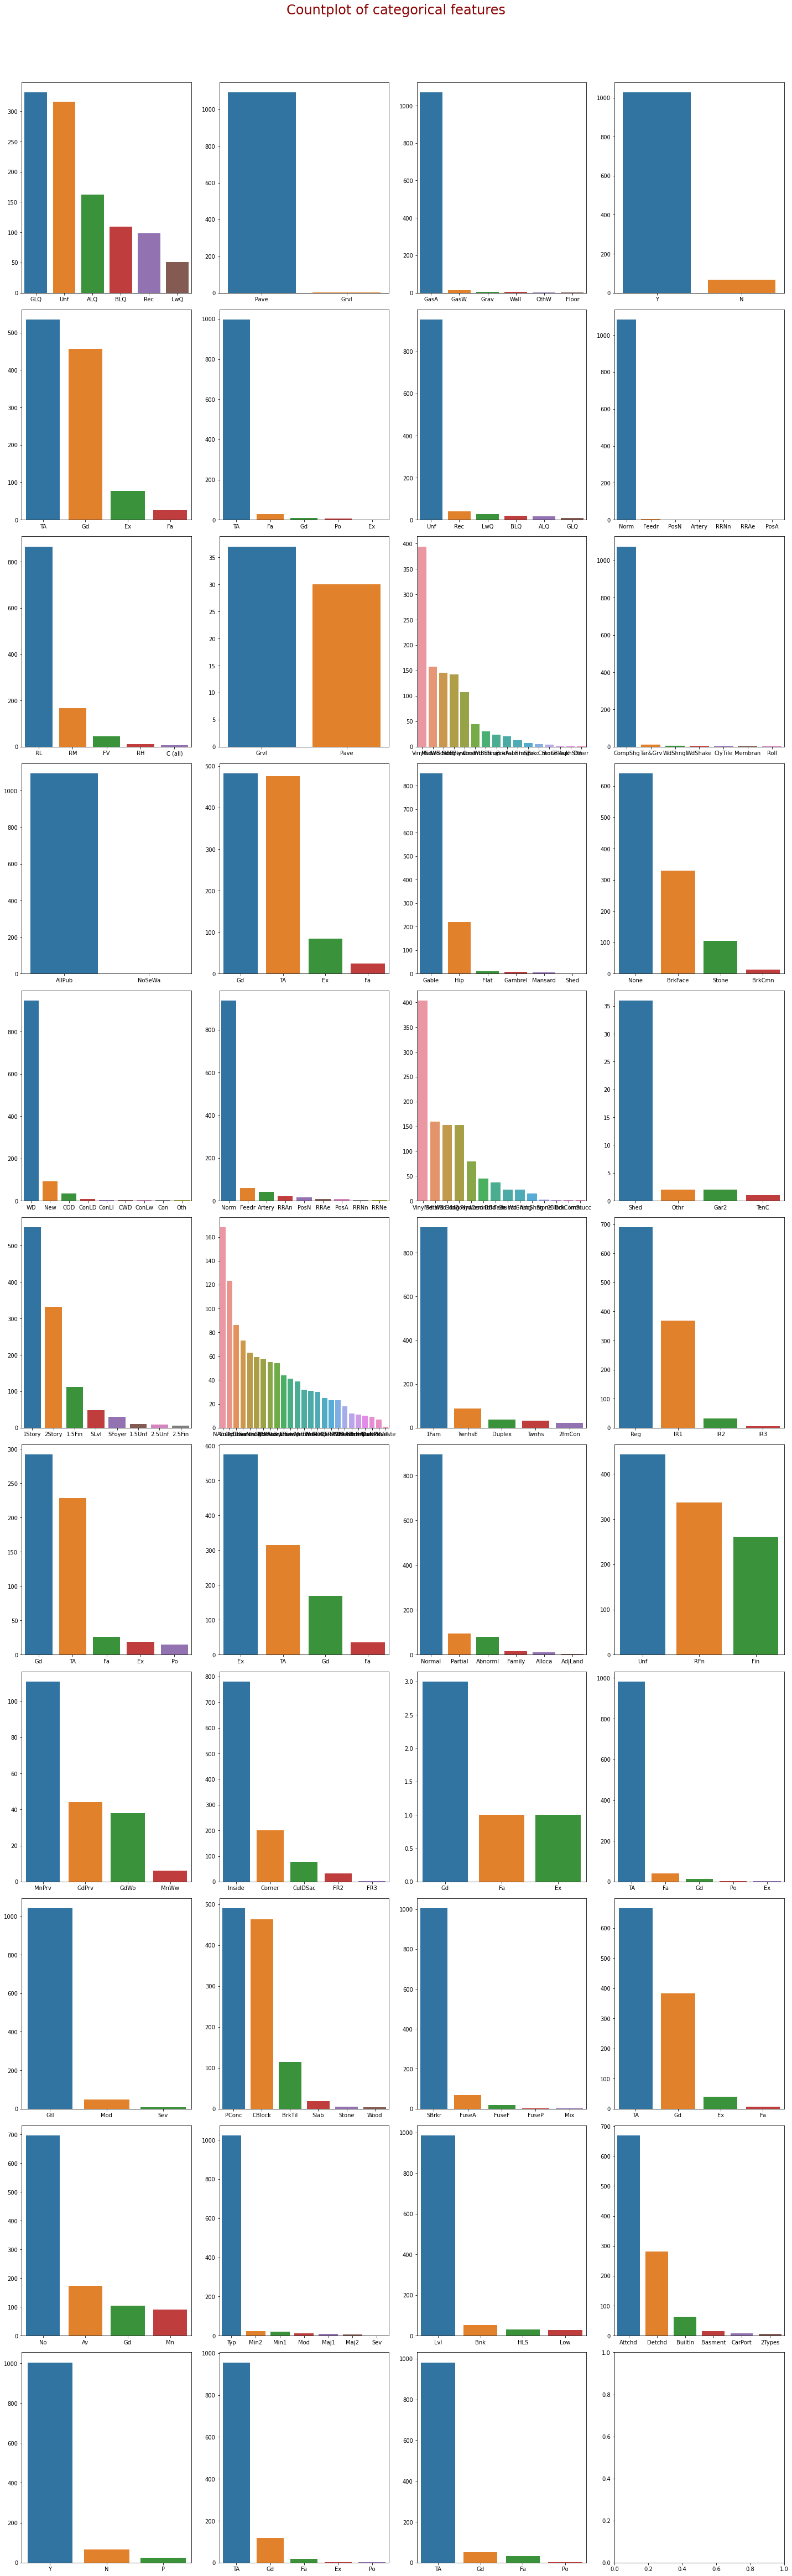

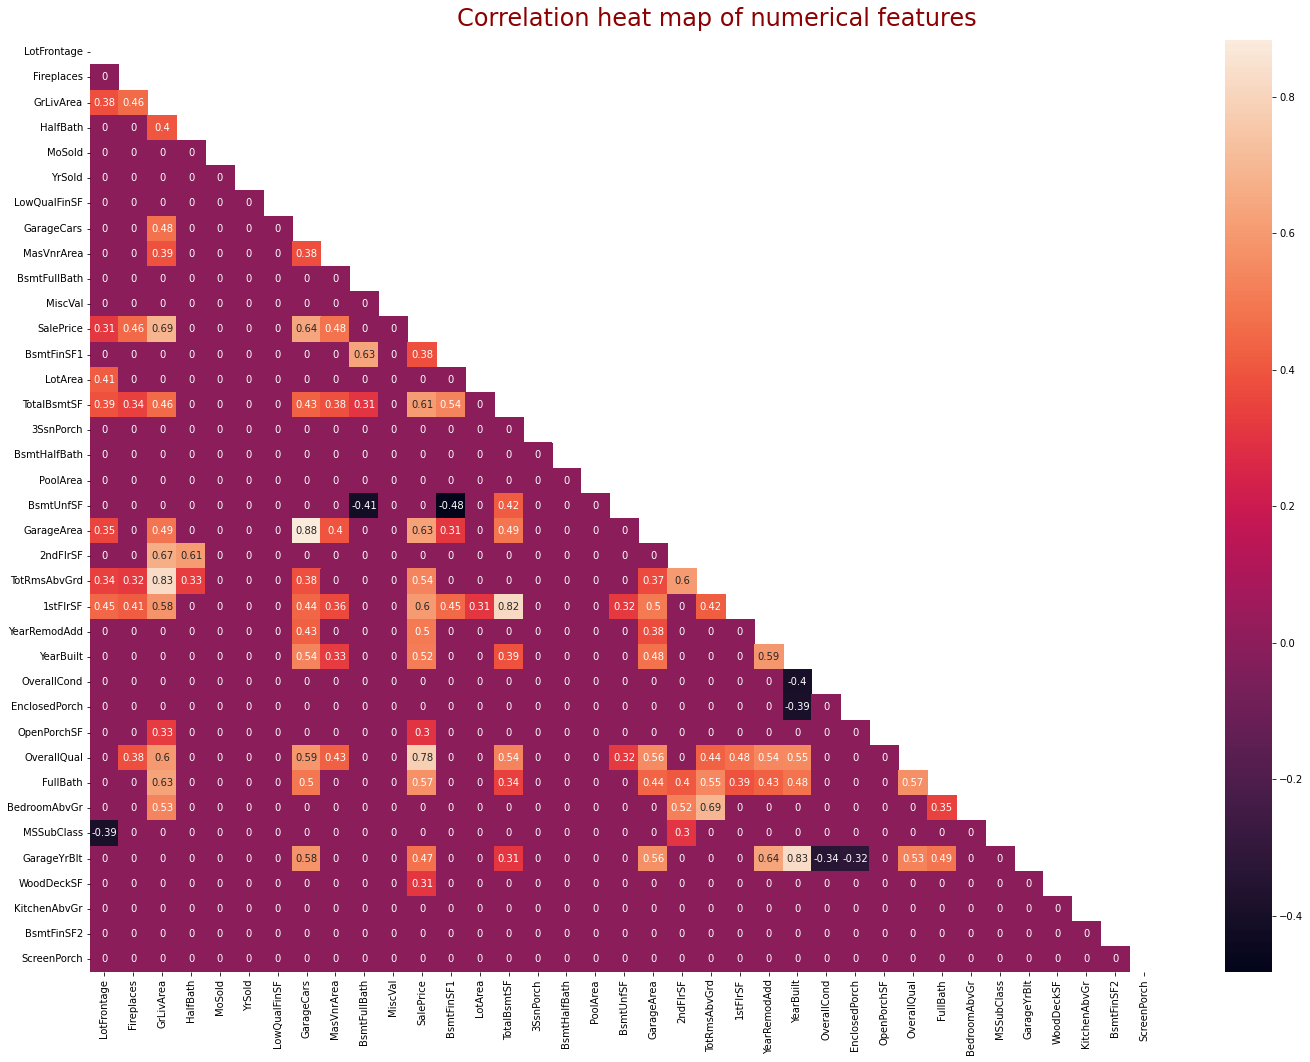

In [10]:
HP.visualize()

## Check data types is correct for numeric and categorical

In [11]:
HP.train_data[HP.grabNumeric()].head()

,LotFrontage,Fireplaces,GrLivArea,HalfBath,MoSold,YrSold,LowQualFinSF,GarageCars,MasVnrArea,BsmtFullBath,MiscVal,SalePrice,BsmtFinSF1,LotArea,TotalBsmtSF,3SsnPorch,BsmtHalfBath,PoolArea,BsmtUnfSF,GarageArea,2ndFlrSF,TotRmsAbvGrd,1stFlrSF,YearRemodAdd,YearBuilt,OverallCond,EnclosedPorch,OpenPorchSF,OverallQual,FullBath,BedroomAbvGr,MSSubClass,GarageYrBlt,WoodDeckSF,KitchenAbvGr,BsmtFinSF2,ScreenPorch
6,75.0,1,1694,0,8,2007,0,2,186.0,1,0,307000,1369,10084,1686,0,0,0,317,636,0,7,1694,2005,2004,5,0,57,8,2,3,20,2004.0,255,1,0,0
807,144.0,1,1576,1,5,2009,0,2,0.0,2,0,223500,1309,21384,1324,0,0,0,15,528,504,6,1072,2004,1923,6,0,312,5,1,3,70,1923.0,0,1,0,0
955,82.0,0,1958,0,8,2007,0,2,423.0,0,0,145000,484,7136,979,0,0,0,495,492,979,8,979,1950,1946,6,0,0,6,2,4,90,1946.0,0,2,0,0
1040,88.0,1,1803,0,1,2006,0,2,67.0,1,0,155000,168,13125,1134,0,0,0,284,484,0,8,1803,2000,1957,4,0,0,5,2,3,20,1957.0,0,1,682,0
701,80.0,0,1164,1,7,2006,0,2,168.0,0,0,140000,0,9600,1164,0,0,0,1164,528,0,6,1164,1969,1969,5,0,0,7,1,3,20,1969.0,0,1,0,0


In [12]:
HP.train_data[HP.grabCategorical()].head()

,BsmtFinType1,Street,Heating,CentralAir,KitchenQual,GarageCond,BsmtFinType2,Condition2,MSZoning,Alley,Exterior2nd,RoofMatl,Utilities,BsmtQual,RoofStyle,MasVnrType,SaleType,Condition1,Exterior1st,MiscFeature,HouseStyle,Neighborhood,BldgType,LotShape,FireplaceQu,HeatingQC,SaleCondition,GarageFinish,Fence,LotConfig,PoolQC,GarageQual,LandSlope,Foundation,Electrical,ExterQual,BsmtExposure,Functional,LandContour,GarageType,PavedDrive,ExterCond,BsmtCond
6,GLQ,Pave,GasA,Y,Gd,TA,Unf,Norm,RL,NaN,VinylSd,CompShg,AllPub,Ex,Gable,Stone,WD,Norm,VinylSd,NaN,1Story,Somerst,1Fam,Reg,Gd,Ex,Normal,RFn,NaN,Inside,NaN,TA,Gtl,PConc,SBrkr,Gd,Av,Typ,Lvl,Attchd,Y,TA,TA
807,GLQ,Pave,GasA,Y,Gd,TA,Unf,Norm,RL,NaN,Wd Sdng,CompShg,AllPub,TA,Gable,None,WD,Norm,Wd Sdng,NaN,2Story,BrkSide,1Fam,Reg,TA,Ex,Normal,RFn,NaN,Inside,NaN,TA,Gtl,CBlock,SBrkr,TA,Gd,Typ,Lvl,Attchd,Y,TA,TA
955,Rec,Pave,GasA,N,TA,TA,Unf,Norm,RH,NaN,MetalSd,CompShg,AllPub,Gd,Gable,BrkFace,WD,Norm,MetalSd,NaN,2Story,Crawfor,Duplex,IR1,NaN,TA,Normal,Unf,NaN,Inside,NaN,TA,Gtl,CBlock,FuseF,TA,No,Typ,HLS,Attchd,Y,TA,TA
1040,Rec,Pave,GasA,Y,TA,TA,BLQ,Norm,RL,NaN,Wd Sdng,CompShg,AllPub,TA,Gable,BrkCmn,WD,Norm,Wd Sdng,NaN,1Story,Sawyer,1Fam,Reg,TA,Ex,Normal,RFn,GdPrv,Corner,NaN,TA,Gtl,CBlock,SBrkr,TA,No,Maj1,Lvl,Attchd,Y,TA,TA
701,Unf,Pave,GasA,Y,TA,TA,Unf,Norm,RL,NaN,HdBoard,CompShg,AllPub,TA,Hip,BrkFace,COD,Norm,HdBoard,NaN,1Story,NWAmes,1Fam,Reg,NaN,TA,Normal,Unf,NaN,Inside,NaN,TA,Gtl,CBlock,SBrkr,TA,No,Typ,Lvl,Attchd,Y,TA,TA


# Pre-Processing

## Handle Null values

In [13]:
null_df = HP.train_data.isna().sum().reset_index().rename(columns={0: "Null Count"})
null_df['Percentage'] = null_df['Null Count']/len(train_data)
null_df[null_df["Null Count"] > 0].sort_values(by="Null Count", ascending=False)

,index,Null Count,Percentage
72,PoolQC,1090,0.995434
74,MiscFeature,1054,0.962557
6,Alley,1028,0.938813
73,Fence,896,0.818265
57,FireplaceQu,515,0.470320
3,LotFrontage,200,0.182648
58,GarageType,54,0.049315
59,GarageYrBlt,54,0.049315
60,GarageFinish,54,0.049315
63,GarageQual,54,0.049315


In [14]:
# null threshold = .45
HP.handleNulls(.45)

In [15]:
null_df = HP.train_data.isna().sum().reset_index().rename(columns={0: "Null Count"})
null_df[null_df["Null Count"] > 0]

,index,Null Count


## Handle redundant col with same value over 80%

In [16]:
HP.handleDuplicates()

['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'BsmtFinSF2',
 'Heating',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SaleType',
 'SaleCondition']

## Visualize data

Skipped cols in count plot due to values > 100: 
 []


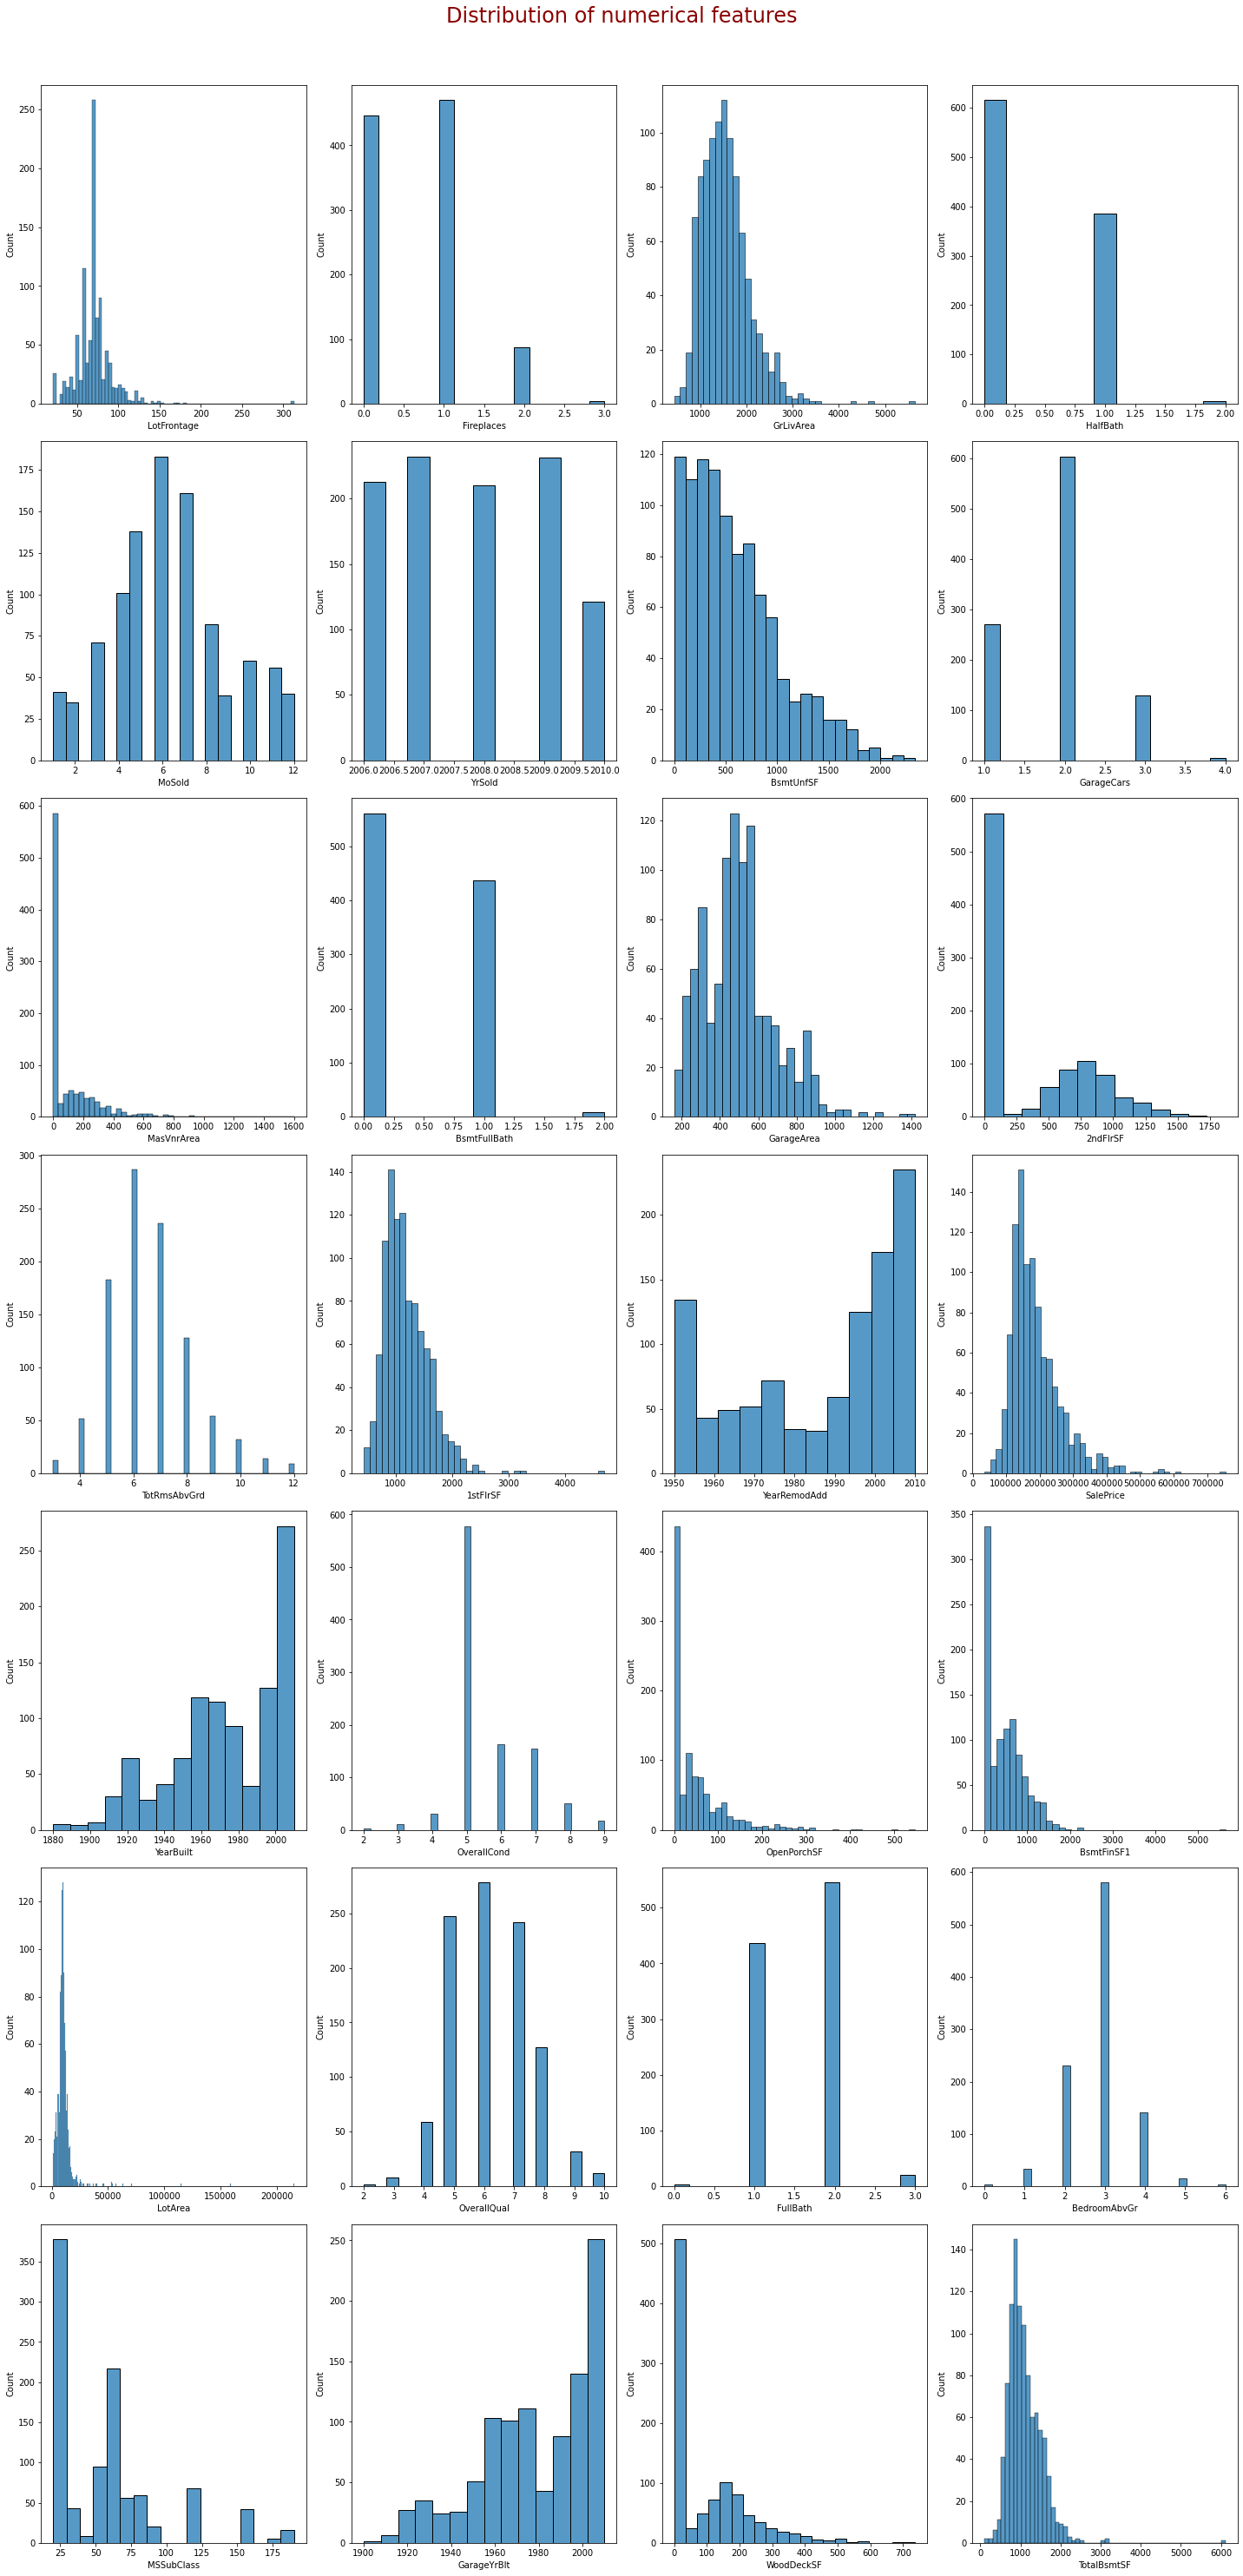

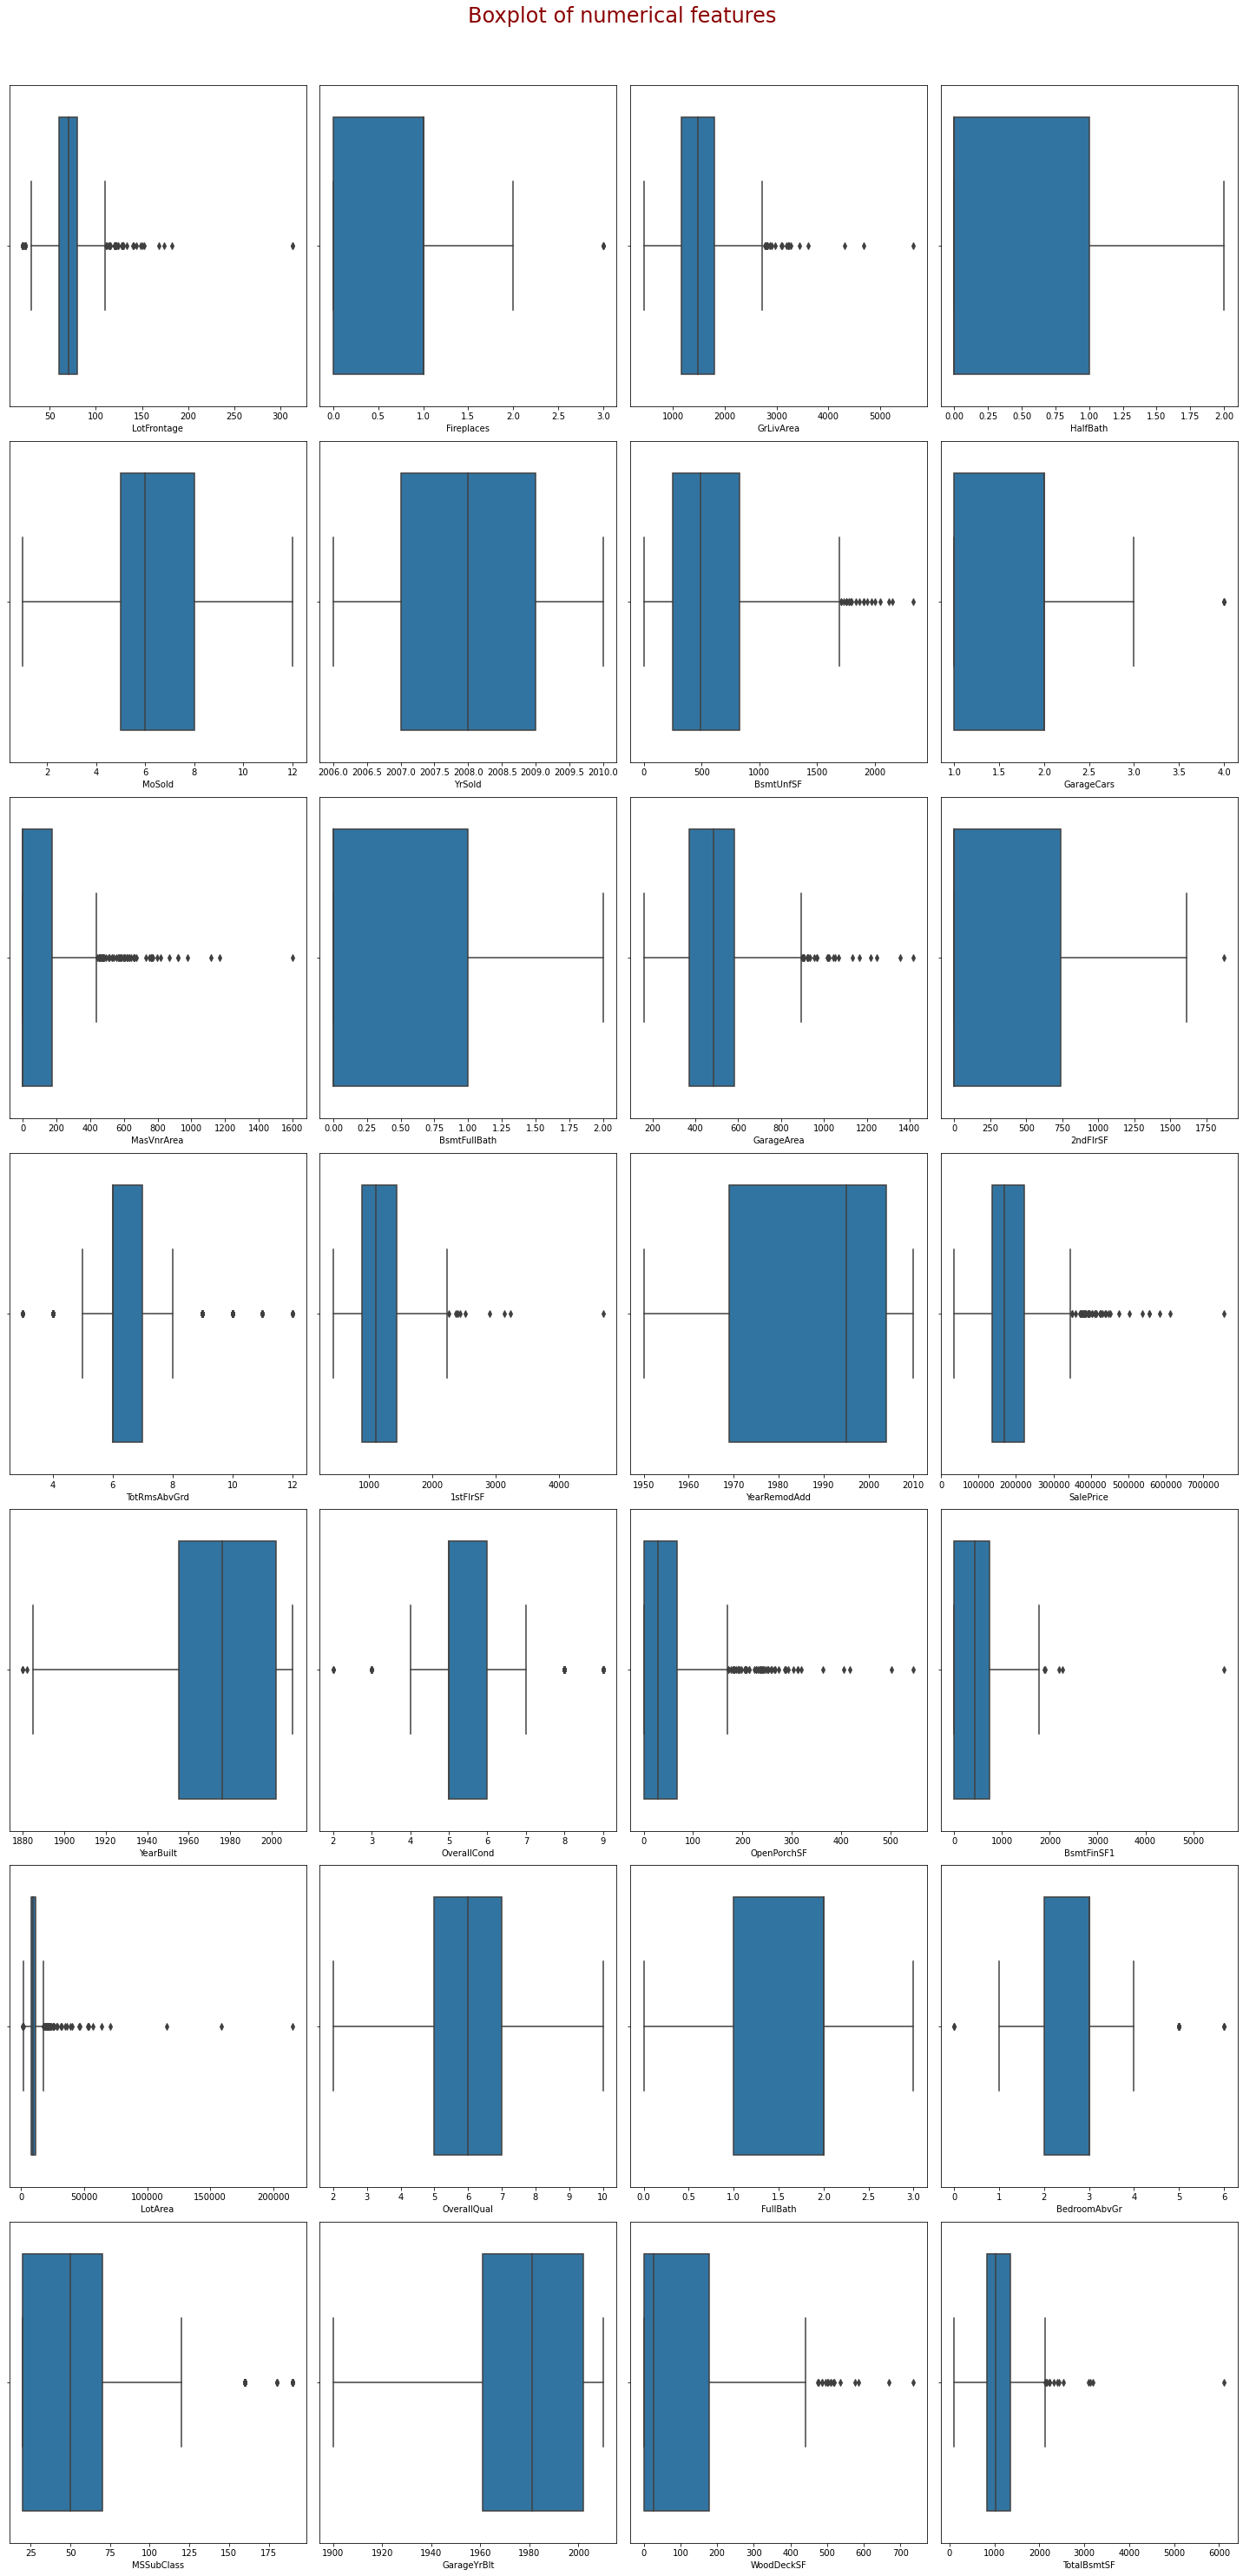

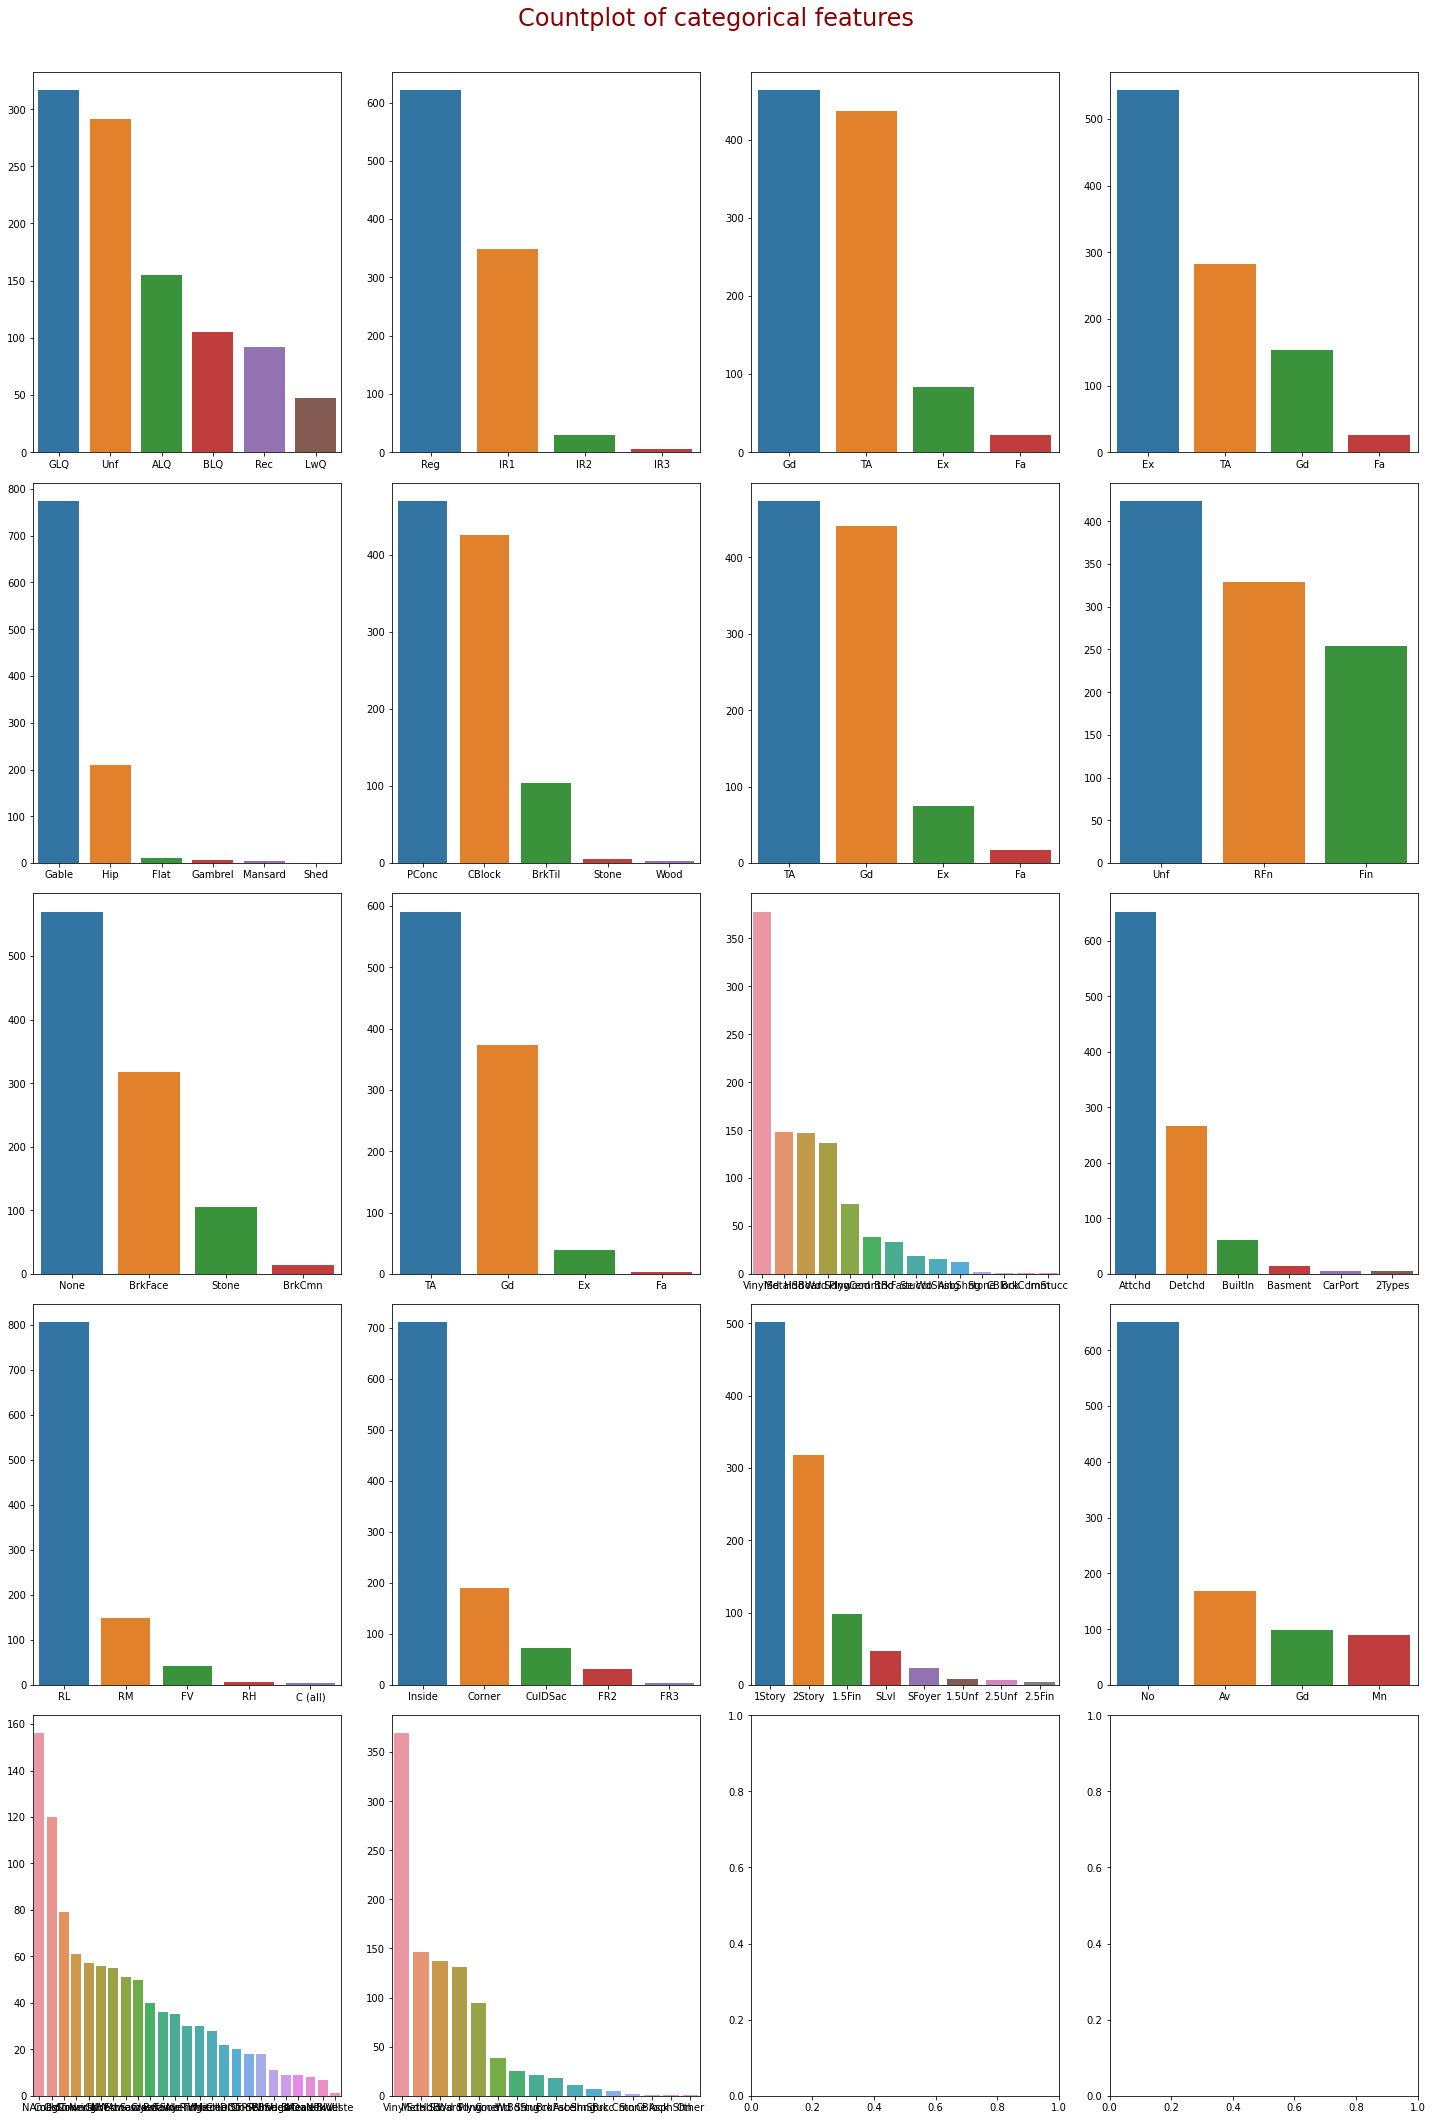

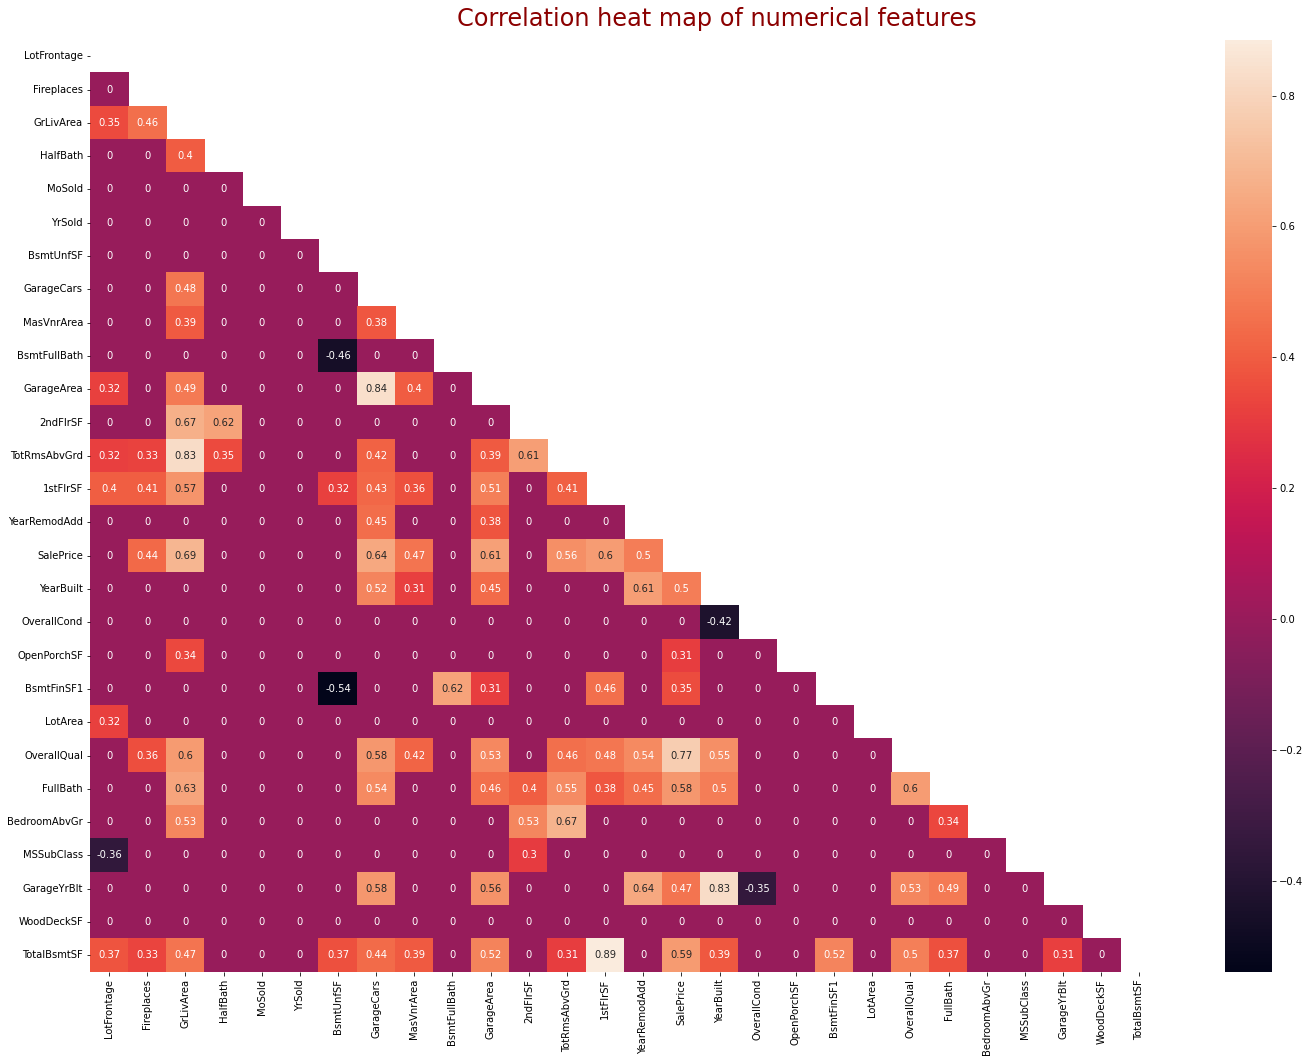

In [17]:
HP.visualize()

## Check for feature correlation

In [18]:
dropedFeature, corrResult = HP.handleCorrFeature()

In [19]:
print("Dropped Features:\n", dropedFeature)
print("Correlation Result:\n", corrResult)

Dropped Features:
 ['GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea']
Correlation Result:
 [{'Feature correlation': 0.8281536439366355, 'Feature YearBuilt vs SalePrice': 0.4975669409332989, 'Feature GarageYrBlt vs SalePrice': 0.47038724475917487}, {'Feature correlation': 0.8856255852224195, 'Feature TotalBsmtSF vs SalePrice': 0.5942451820304427, 'Feature 1stFlrSF vs SalePrice': 0.6011577817235064}, {'Feature correlation': 0.8265071510786629, 'Feature GrLivArea vs SalePrice': 0.6872007162369558, 'Feature TotRmsAbvGrd vs SalePrice': 0.5556307443381582}, {'Feature correlation': 0.8393168079883067, 'Feature GarageCars vs SalePrice': 0.638586747288034, 'Feature GarageArea vs SalePrice': 0.6105239802041376}]


## Clamping outliers

Sale price had outliers in it do we remove outliers from target ?!

In [20]:
outlierdCols = HP.checkOutliers()
for c in outlierdCols:
    print(c)
    print(outlierdCols[c])

MSSubClass
{'Lower Bound': -55.0, 'Below Lower': [], 'Upper Bound': 145.0, 'Above Upper': [1086, 623, 1393, 1062, 1172, 713, 180, 363, 1304, 9, 430, 300, 703, 675, 172, 1186, 959, 472, 1297, 578, 655, 962, 193, 1091, 1007, 411, 1364, 246, 969, 500, 344, 285, 603, 504, 915, 956, 1452, 312, 971, 1265, 488, 232, 225, 93, 758, 837, 637, 975, 1191, 145, 1266, 687, 1291, 1160, 1236, 1039, 489, 243, 1190, 1088, 829, 914, 235]}
LotFrontage
{'Lower Bound': 30.0, 'Below Lower': [363, 430, 675, 959, 655, 962, 193, 1091, 1007, 500, 504, 915, 956, 232, 225, 758, 837, 1191, 145, 1291, 1160, 1039, 489, 1088, 829, 235], 'Upper Bound': 110.0, 'Above Upper': [807, 41, 1339, 1127, 825, 85, 1298, 1361, 260, 306, 320, 1168, 991, 909, 1273, 276, 906, 277, 429, 662, 523, 963, 1211, 197, 934, 36, 1107, 1151, 171, 1359, 150, 290, 86, 889, 313, 1061]}
LotArea
{'Lower Bound': 1575.5, 'Below Lower': [956, 1039, 489], 'Upper Bound': 17887.5, 'Above Upper': [807, 664, 558, 1446, 349, 828, 1298, 692, 260, 1287, 457,

In [21]:
HP.handleOutliers()

In [22]:
outlierdCols = HP.checkOutliers()
for c in outlierdCols:
    print(outlierdCols[c])

{'Lower Bound': -55.0, 'Below Lower': [], 'Upper Bound': 145.0, 'Above Upper': []}
{'Lower Bound': 30.0, 'Below Lower': [], 'Upper Bound': 110.0, 'Above Upper': []}
{'Lower Bound': 1575.5, 'Below Lower': [], 'Upper Bound': 17887.5, 'Above Upper': []}
{'Lower Bound': 2.0, 'Below Lower': [], 'Upper Bound': 10.0, 'Above Upper': []}
{'Lower Bound': 3.5, 'Below Lower': [], 'Upper Bound': 7.5, 'Above Upper': []}
{'Lower Bound': 1884.5, 'Below Lower': [], 'Upper Bound': 2072.5, 'Above Upper': []}
{'Lower Bound': 1916.5, 'Below Lower': [], 'Upper Bound': 2056.5, 'Above Upper': []}
{'Lower Bound': -264.0, 'Below Lower': [], 'Upper Bound': 440.0, 'Above Upper': []}
{'Lower Bound': -1102.5, 'Below Lower': [], 'Upper Bound': 1837.5, 'Above Upper': []}
{'Lower Bound': -618.0, 'Below Lower': [], 'Upper Bound': 1702.0, 'Above Upper': []}
{'Lower Bound': 87.75, 'Below Lower': [], 'Upper Bound': 2237.75, 'Above Upper': []}
{'Lower Bound': -1111.5, 'Below Lower': [], 'Upper Bound': 1852.5, 'Above Upper'

## Check skewness of data

In [23]:
HP.calcSkew(target=True)

,Skew Value
LotFrontage,0.051443
Fireplaces,0.510707
GrLivArea,0.598242
HalfBath,0.574548
MoSold,0.226654
YrSold,0.103520
BsmtUnfSF,0.810250
GarageCars,0.130754
MasVnrArea,1.252793
BsmtFullBath,0.388952


In [24]:
HP.handleSkew(target=True)

In [25]:
HP.calcSkew(target=True)

,Skew Value
LotFrontage,0.051443
Fireplaces,0.510707
GrLivArea,0.598242
HalfBath,0.574548
MoSold,0.226654
YrSold,0.103520
BsmtUnfSF,0.810250
GarageCars,0.130754
MasVnrArea,0.357003
BsmtFullBath,0.388952


## Check distribution and feature scaling

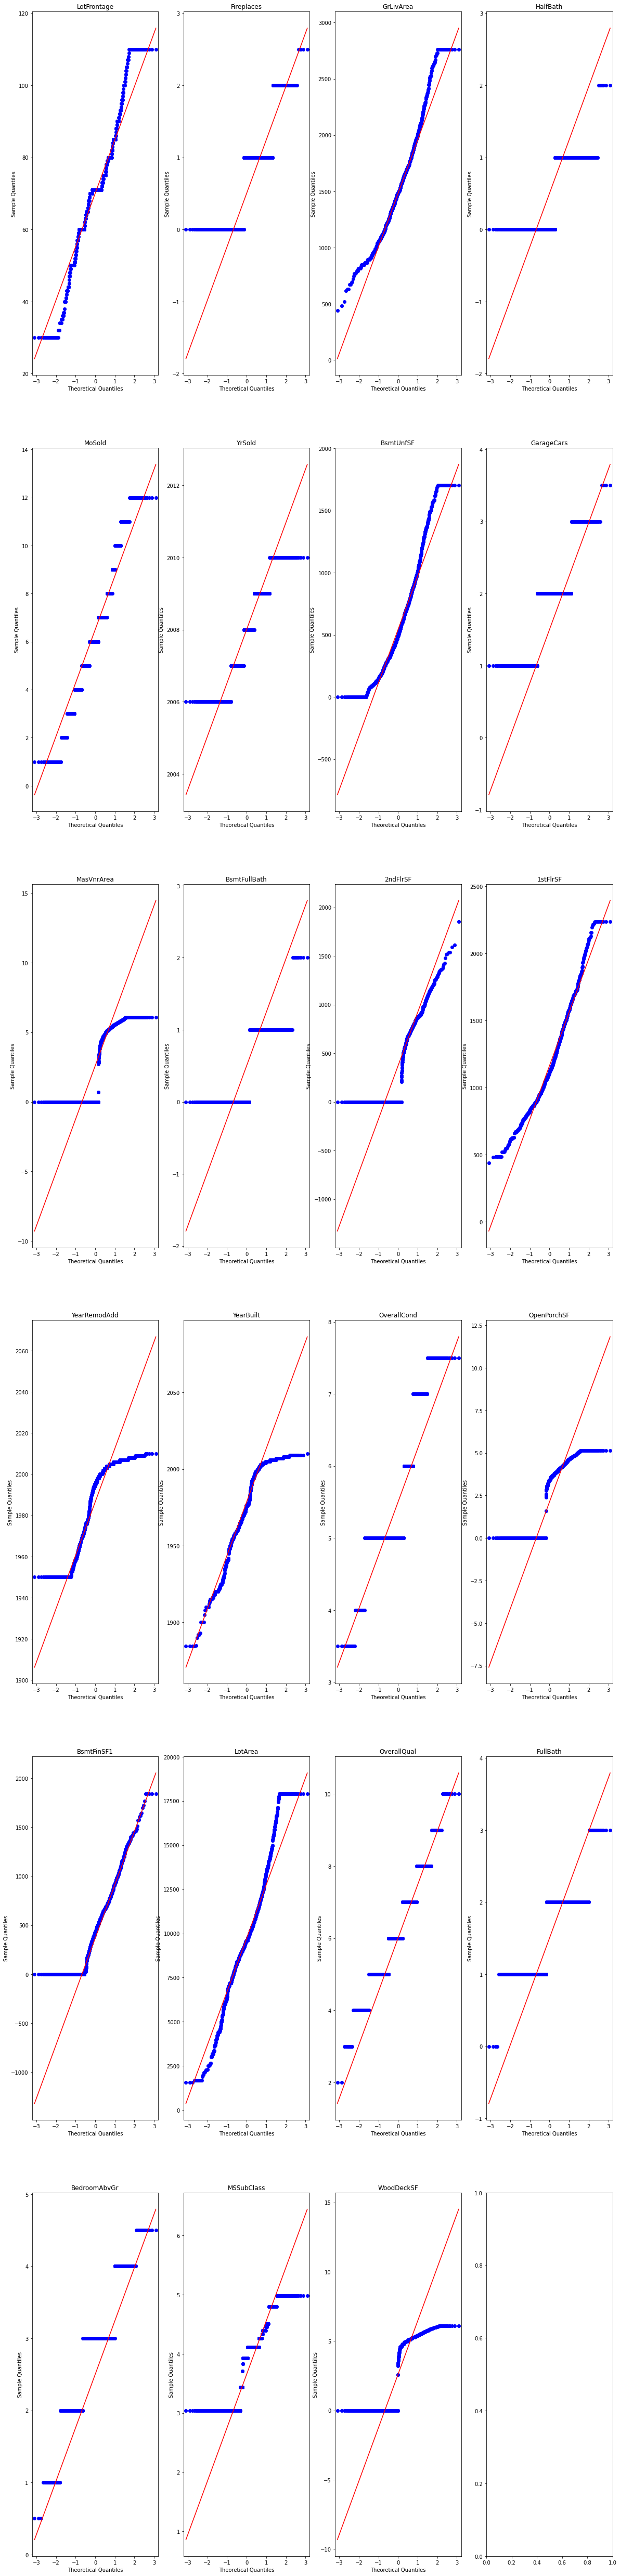

In [26]:
HP.drawQQ()

In [27]:
HP.alpha = .001
gaussianFeatures, nonGaussianFeatures = HP.checkDistribution()

W_Statistic=0.964, p=0.00000000
LotFrontage does not look Gaussian (reject H0)
W_Statistic=0.766, p=0.00000000
Fireplaces does not look Gaussian (reject H0)
W_Statistic=0.976, p=0.00000032
GrLivArea does not look Gaussian (reject H0)
W_Statistic=0.634, p=0.00000000
HalfBath does not look Gaussian (reject H0)
W_Statistic=0.968, p=0.00000000
MoSold does not look Gaussian (reject H0)
W_Statistic=0.900, p=0.00000000
YrSold does not look Gaussian (reject H0)
W_Statistic=0.932, p=0.00000000
BsmtUnfSF does not look Gaussian (reject H0)
W_Statistic=0.780, p=0.00000000
GarageCars does not look Gaussian (reject H0)
W_Statistic=0.708, p=0.00000000
MasVnrArea does not look Gaussian (reject H0)
W_Statistic=0.664, p=0.00000000
BsmtFullBath does not look Gaussian (reject H0)
W_Statistic=0.770, p=0.00000000
2ndFlrSF does not look Gaussian (reject H0)
W_Statistic=0.954, p=0.00000000
1stFlrSF does not look Gaussian (reject H0)
W_Statistic=0.857, p=0.00000000
YearRemodAdd does not look Gaussian (reject H

In [28]:
HP.train_data[gaussianFeatures].head()

""
6
807
955
1040
701


In [29]:
HP.train_data[nonGaussianFeatures].head()

,LotFrontage,Fireplaces,GrLivArea,HalfBath,MoSold,YrSold,BsmtUnfSF,GarageCars,MasVnrArea,BsmtFullBath,2ndFlrSF,1stFlrSF,YearRemodAdd,SalePrice,YearBuilt,OverallCond,OpenPorchSF,BsmtFinSF1,LotArea,OverallQual,FullBath,BedroomAbvGr,MSSubClass,WoodDeckSF
6,75.0,1.0,1694,0,8,2007,317,2.0,5.231109,1,0.0,1694.0,2005,12.634606,2004.0,5.0,4.060443,1369.0,10084.0,8,2,3.0,3.044522,5.545177
807,110.0,1.0,1576,1,5,2009,15,2.0,0.000000,2,504.0,1072.0,2004,12.317171,1923.0,6.0,5.141664,1309.0,17887.5,5,1,3.0,4.262680,0.000000
955,82.0,0.0,1958,0,8,2007,495,2.0,6.049733,0,979.0,979.0,1950,11.884496,1946.0,6.0,0.000000,484.0,7136.0,6,2,4.0,4.510860,0.000000
1040,88.0,1.0,1803,0,1,2006,284,2.0,4.219508,1,0.0,1803.0,2000,11.951187,1957.0,4.0,0.000000,168.0,13125.0,5,2,3.0,3.044522,0.000000
701,80.0,0.0,1164,1,7,2006,1164,2.0,5.129899,0,0.0,1164.0,1969,11.849405,1969.0,5.0,0.000000,0.0,9600.0,7,1,3.0,3.044522,0.000000


In [30]:
HP.train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,GarageType,GarageFinish,GarageCars,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
6,7,3.044522,RL,75.0,10084.0,Reg,Inside,Somerst,1Story,8,5.0,2004.0,2005,Gable,VinylSd,VinylSd,Stone,5.231109,Gd,PConc,Ex,Av,GLQ,1369.0,317,Ex,1694.0,0.0,1694,1,2,0,3.0,Gd,1.0,Attchd,RFn,2.0,5.545177,4.060443,8,2007,12.634606
807,808,4.262680,RL,110.0,17887.5,Reg,Inside,BrkSide,2Story,5,6.0,1923.0,2004,Gable,Wd Sdng,Wd Sdng,None,0.000000,TA,CBlock,TA,Gd,GLQ,1309.0,15,Ex,1072.0,504.0,1576,2,1,1,3.0,Gd,1.0,Attchd,RFn,2.0,0.000000,5.141664,5,2009,12.317171
955,956,4.510860,RH,82.0,7136.0,IR1,Inside,Crawfor,2Story,6,6.0,1946.0,1950,Gable,MetalSd,MetalSd,BrkFace,6.049733,TA,CBlock,Gd,No,Rec,484.0,495,TA,979.0,979.0,1958,0,2,0,4.0,TA,0.0,Attchd,Unf,2.0,0.000000,0.000000,8,2007,11.884496
1040,1041,3.044522,RL,88.0,13125.0,Reg,Corner,Sawyer,1Story,5,4.0,1957.0,2000,Gable,Wd Sdng,Wd Sdng,BrkCmn,4.219508,TA,CBlock,TA,No,Rec,168.0,284,Ex,1803.0,0.0,1803,1,2,0,3.0,TA,1.0,Attchd,RFn,2.0,0.000000,0.000000,1,2006,11.951187
701,702,3.044522,RL,80.0,9600.0,Reg,Inside,NWAmes,1Story,7,5.0,1969.0,1969,Hip,HdBoard,HdBoard,BrkFace,5.129899,TA,CBlock,TA,No,Unf,0.0,1164,TA,1164.0,0.0,1164,0,1,1,3.0,TA,0.0,Attchd,Unf,2.0,0.000000,0.000000,7,2006,11.849405


## Categorical data

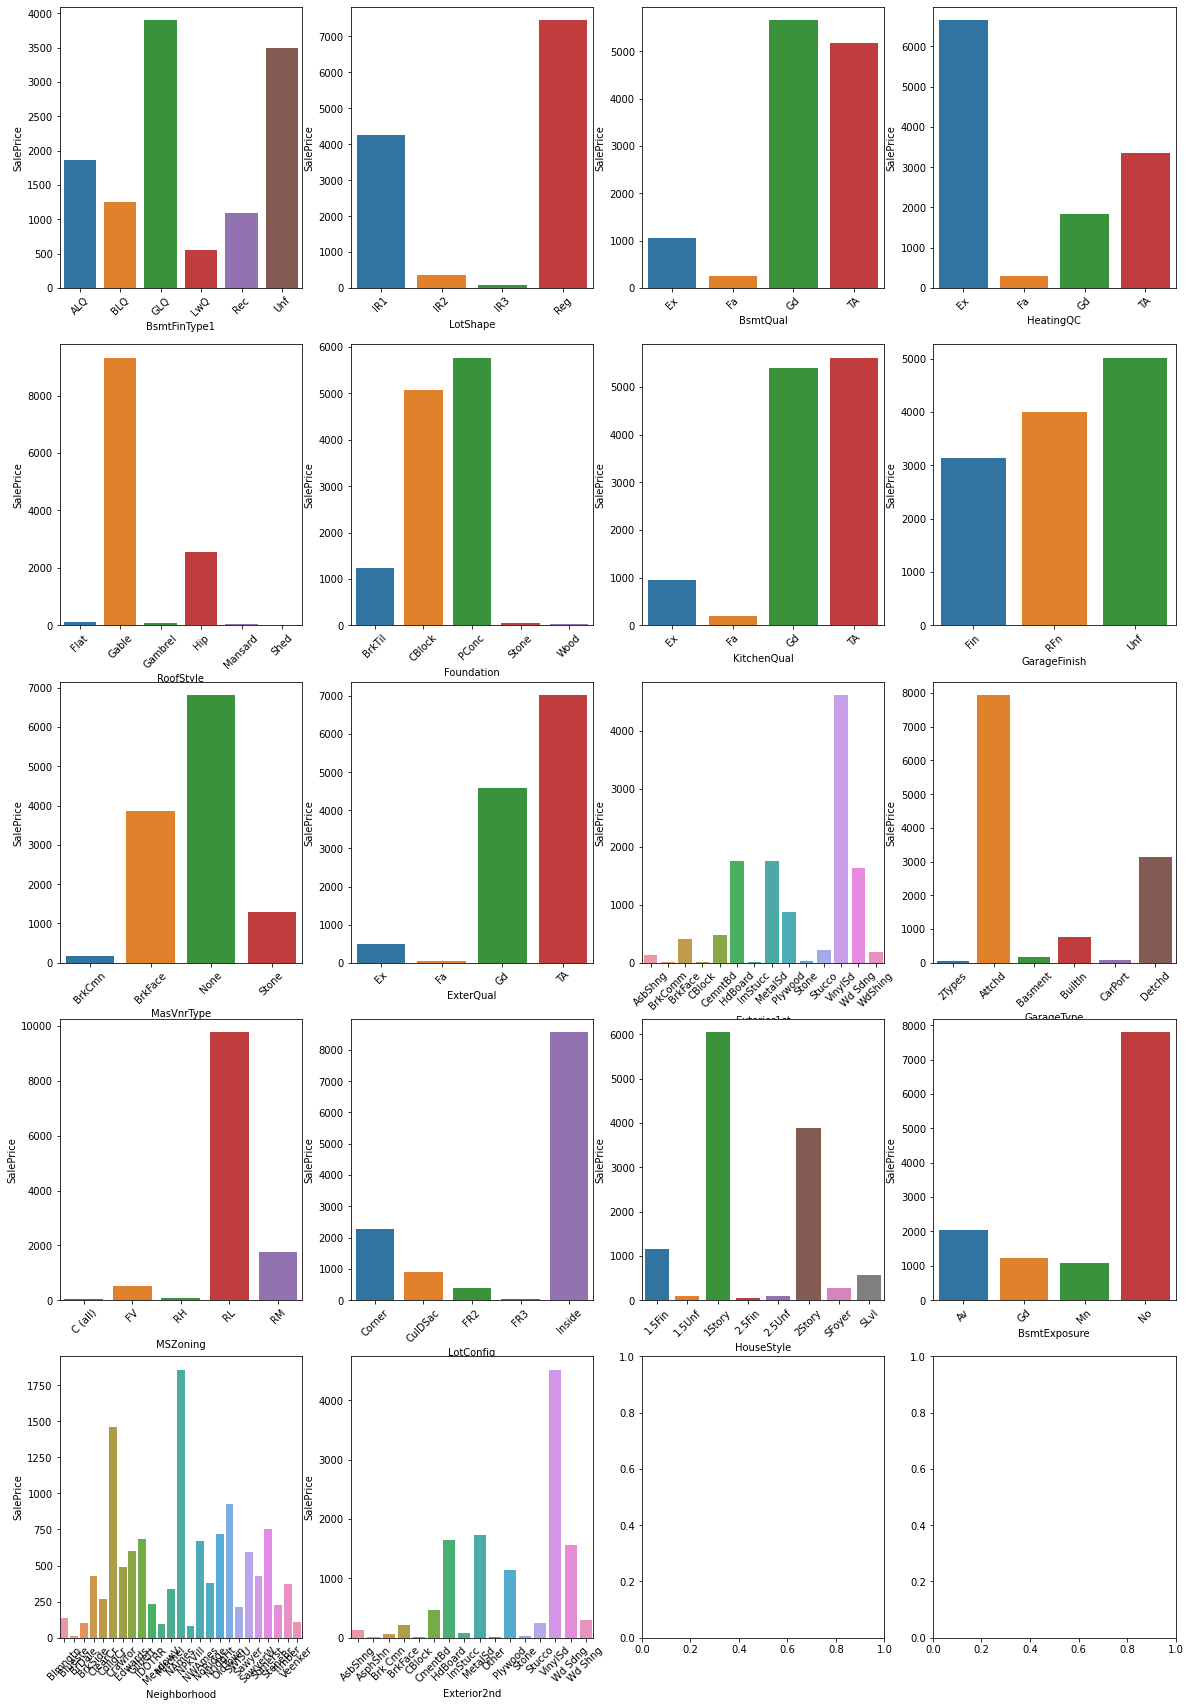

In [31]:
cat = HP.grabCategorical()
nC = 4
nR = len(cat)//4 if len(cat) % 4 == 0 else len(cat)//4 +1
fig, axes = plt.subplots(nrows=nR, ncols=nC, figsize=(20, 30))
i = 0
j = 0
for c in cat:
    p = HP.train_data.groupby(c)[HP.target].sum()
    sns.barplot(x=p.index, y=p, ax=axes[i, j]).set_xticklabels(axes[i, j].get_xticklabels(),rotation=45)
    if j < nC-1:
        j+=1
    else:
        j=0
        i+=1


In [32]:
ordinal_cats = ['BsmtQual', 'LotShape', 'HeatingQC', 'BsmtFinType1',  'ExterQual', 
                 'KitchenQual', 'BsmtExposure', 'GarageFinish']
nominal_cats = ['HouseStyle', 'LotConfig', 'RoofStyle', 'GarageType', 'Exterior1st', 
                'Foundation', 'Exterior2nd', 'MasVnrType', 'Neighborhood']

In [33]:
rating = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
ordinal_encoding = {
        'LotShape': {'None': 0, 'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4},
        'ExterQual': rating,
        'BsmtQual': rating,
        'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
        'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
        'HeatingQC': rating,
        'KitchenQual': rating,
        'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
    }

## Train Data

In [34]:
idx = HP.train_data[nominal_cats].index.to_numpy().reshape((-1, 1))

In [35]:
ordinalDF = pd.DataFrame()
for c in ordinal_cats:
    ordinalDF[c] = HP.train_data[c].replace(ordinal_encoding[c])
ordinalDF['index'] = idx

In [36]:
train_OHE = OneHotEncoder(sparse=False)
train_OHE = train_OHE.fit(HP.train_data[nominal_cats])
nDF = train_OHE.transform(HP.train_data[nominal_cats])
nDF = np.c_[idx, nDF]
nominalDF = pd.DataFrame(nDF, columns=['index'] + train_OHE.get_feature_names_out().tolist())

In [37]:
nominalDF = nominalDF.loc[:,~nominalDF.columns.duplicated()]

In [38]:
numCols = HP.train_data[HP.grabNumeric()]
numCols['index'] = idx

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
final_data = numCols.merge(ordinalDF, on='index').merge(nominalDF, on='index')

In [40]:
print(ordinalDF.shape)
print(nominalDF.shape)
print(numCols.shape)
print(final_data.shape)

(1007, 9)
(1007, 90)
(1007, 25)
(1007, 122)


## Test Data

In [41]:
t_idx = HP.test_data[nominal_cats].index.to_numpy().reshape((-1, 1))

In [42]:
tordinalDF = pd.DataFrame()
for c in ordinal_cats:
    tordinalDF[c] = HP.test_data[c].replace(ordinal_encoding[c])
tordinalDF['index'] = t_idx

In [43]:
tnDF = np.c_[t_idx, train_OHE.transform(HP.test_data[nominal_cats])]   
tnominalDF = pd.DataFrame(tnDF, columns=['index'] + train_OHE.get_feature_names_out().tolist())

In [44]:
tnominalDF = tnominalDF.loc[:,~tnominalDF.columns.duplicated()]

In [45]:
tnumCols = HP.test_data[HP.grabNumeric()]
tnumCols['index'] = t_idx

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
final_test_data = tnumCols.merge(tordinalDF, on='index').merge(tnominalDF, on='index')

In [47]:
print(tordinalDF.shape)
print(tnominalDF.shape)
print(tnumCols.shape)
print(final_test_data.shape)

(273, 9)
(273, 90)
(273, 25)
(273, 122)


# Fitting model to data

In [48]:
from sklearn.metrics import mean_squared_error

#### Note
adjusted r2_score happens to be negative if the number of samples is less than the number of independent variables so the degree of freedom is negative then the adjusted r2_score gets values greater than 1 and another case when the R2 is negative itself

In [49]:
def EvaluateModel(X, actual, predicted):
    # mse
    print('The mean squared error is: ', np.mean(np.square(actual-predicted)))
    #rmse
    print('the root mean squard error is: ', np.sqrt(np.mean(np.square(actual-predicted))))
    #mae
    print('The mean absolute error is: ', np.mean(np.abs(actual-predicted)))
    #mape
    print('The mean absolute perentage error is: ', np.mean(np.abs((actual - predicted) / (actual + 1e-5))) * 100)
    #rae
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    print('The relative absolute error is: ', numerator / denominator)
    # r_squared
    sse = np.sum(np.square(actual-predicted))
    sst = np.sum(np.square(actual-np.mean(actual)))
    r_squared = 1 - (sse/sst)
    print('The coefficient of determination is: ', r_squared)
    #adjusted r_squared
    adj_r2 = 1 - (((1-r_squared) * (X.shape[0]-1 ))/(X.shape[0] - X.shape[1] -1 ))
    print('The adjusted coefficient of determination is: ', adj_r2)


### Train Test Data

In [50]:
train_data_y = final_data['SalePrice']
train_data_x = final_data.drop(columns='SalePrice')

In [51]:
test_data_y = final_test_data['SalePrice']
test_data_x = final_test_data.drop(columns='SalePrice')

In [52]:
scaler = MinMaxScaler()
xTrain = scaler.fit_transform(train_data_x)
xTest = scaler.transform(test_data_x)

In [53]:
yTrain = train_data_y
yTest = test_data_y

# Models

In [54]:
LR = LinearRegression()
LR.fit(xTrain, yTrain)
print("Train Score: ", LR.score(xTrain, yTrain))

Train Score:  0.9121875004133004


In [55]:
y_train = LR.predict(xTrain)

In [56]:
print("Linear Regression Model Evaluation on Training Data")
EvaluateModel(xTrain, yTrain, y_train)

Linear Regression Model Evaluation on Training Data
The mean squared error is:  0.012107066489783358
the root mean squard error is:  0.1100321157198359
The mean absolute error is:  0.07597050554100072
The mean absolute perentage error is:  0.6308263730049124
The relative absolute error is:  0.26034022737274043
The coefficient of determination is:  0.9121875004133004
The adjusted coefficient of determination is:  0.9001814976449494


In [57]:
y_test = LR.predict(xTest)

In [58]:
print("Linear Regression Model Evaluation on Testing Data")
EvaluateModel(xTest, yTest, y_test)

Linear Regression Model Evaluation on Testing Data
The mean squared error is:  0.017401429540152648
the root mean squard error is:  0.13191447812940263
The mean absolute error is:  0.09094877201057204
The mean absolute perentage error is:  0.7661829834941357
The relative absolute error is:  0.29083850598197136
The coefficient of determination is:  0.8959059024838697
The adjusted coefficient of determination is:  0.8124927514941229


## Ridge

In [59]:
from sklearn.linear_model import Ridge

In [60]:
x = np.linspace(.1, 1, 10)
result = {}
for a in x:
    sklearn_ridge = Ridge(alpha = a, fit_intercept=True)
    sklearn_ridge.fit(xTrain, yTrain)
    y_ridge_sklearn = sklearn_ridge.predict(xTrain)
    result[a] = mean_squared_error(yTrain, y_ridge_sklearn)
    
best_alpha = min(result, key=lambda x: result[x])
print(f"best alpha = {best_alpha} | MSE with it= ", result[best_alpha])

best alpha = 0.1 | MSE with it=  0.012116237521916085


In [61]:
sklearn_ridge = Ridge(alpha = 0.1, fit_intercept=True)
sklearn_ridge.fit(xTrain, yTrain)

Ridge(alpha=0.1)

In [62]:
y_train_ridge = sklearn_ridge.predict(xTrain)

In [63]:
print("Ridge Regression Model Evaluation on Training Data")
EvaluateModel(xTrain, yTrain, y_train_ridge)

Ridge Regression Model Evaluation on Training Data
The mean squared error is:  0.012116237521916068
the root mean squard error is:  0.11007378217321356
The mean absolute error is:  0.07598711115598193
The mean absolute perentage error is:  0.6310517734590482
The relative absolute error is:  0.2603971324775454
The coefficient of determination is:  0.9121209829578919
The adjusted coefficient of determination is:  0.9001058857125868


In [64]:
y_test_ridge = sklearn_ridge.predict(xTest)

In [65]:
print("Ridge Regression Model Evaluation on Testing Data")
EvaluateModel(xTest, yTest, y_test_ridge)

Ridge Regression Model Evaluation on Testing Data
The mean squared error is:  0.01734838385879876
the root mean squard error is:  0.13171326379221934
The mean absolute error is:  0.09072489578536465
The mean absolute perentage error is:  0.7642769709757566
The relative absolute error is:  0.29012258837885496
The coefficient of determination is:  0.8962232179271167
The adjusted coefficient of determination is:  0.8130643395773227


## Lasso

In [66]:
from sklearn.linear_model import Lasso

In [67]:
x = np.linspace(.001, .009, 9)
result2 = {}
for a in x:
    sklearn_Lasso = Lasso(alpha = a)
    sklearn_Lasso.fit(xTrain, yTrain)
    y_Lasso_sklearn = sklearn_Lasso.predict(xTrain)
    result2[a] = mean_squared_error(yTrain, y_Lasso_sklearn)
    
best_alpha = min(result2, key=lambda x: result2[x])
print(f"best alpha = {best_alpha} | MSE with it= ", result2[best_alpha])

best alpha = 0.001 | MSE with it=  0.013877422300703945


In [68]:
from sklearn.linear_model import Lasso

sklearn_Lasso = Lasso(alpha = 0.001)
sklearn_Lasso.fit(xTrain, yTrain)

Lasso(alpha=0.001)

In [69]:
y_train_lasso = sklearn_Lasso.predict(xTrain)

In [70]:
print("Lasso Regression Model Evaluation on Training Data")
EvaluateModel(xTrain, yTrain, y_train_lasso)

Lasso Regression Model Evaluation on Training Data
The mean squared error is:  0.013877422300703945
the root mean squard error is:  0.11780247153902988
The mean absolute error is:  0.0803645120613417
The mean absolute perentage error is:  0.6678852117106896
The relative absolute error is:  0.27539786913037634
The coefficient of determination is:  0.899347117563668
The adjusted coefficient of determination is:  0.8855855370271752


In [71]:
y_test_lasso = sklearn_Lasso.predict(xTest)

In [72]:
print("Lasso Regression Model Evaluation on Testing Data")
EvaluateModel(xTest, yTest, y_test_lasso)

Lasso Regression Model Evaluation on Testing Data
The mean squared error is:  0.016943762653539685
the root mean squard error is:  0.13016820907402732
The mean absolute error is:  0.08804418177915627
The mean absolute perentage error is:  0.7428448927997926
The relative absolute error is:  0.2815501267689283
The coefficient of determination is:  0.8986436328189015
The adjusted coefficient of determination is:  0.8174242922300742


## Gradient descent from scratch

In [73]:
D = np.c_[xTrain, yTrain]

In [74]:
gd = GradientDescent(data=D, alpha=.1)

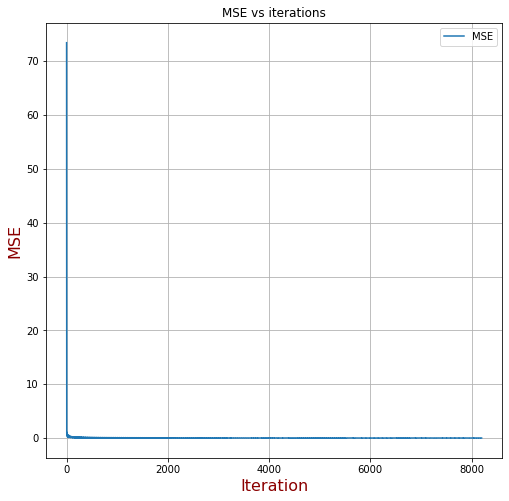

r2_score:  0.8987557212653151
Optimizer:  Mini Batch GD
Batch size:  25
Total number of iterations:  8200
alpha:  0.1
Optimal thetas values:
 [[ 4.57782599e+00]
 [ 3.66872488e-02]
 [ 7.09780202e-02]
 [ 5.99531809e-01]
 [ 3.94229963e-02]
 [ 8.69230343e-03]
 [-1.37255528e-02]
 [-2.50681176e-02]
 [ 9.70632216e-02]
 [ 6.25366944e-02]
 [ 3.45954940e-02]
 [ 1.49170018e-01]
 [ 5.26243035e-02]
 [ 2.85090565e-02]
 [ 3.88831759e-01]
 [ 2.20653720e-01]
 [ 3.19915584e-02]
 [ 6.87797747e-02]
 [ 1.71824679e-01]
 [ 4.07919664e-01]
 [ 3.46660300e-03]
 [ 5.00735177e-02]
 [-7.94920086e-02]
 [ 6.10753598e-03]
 [-1.11527145e-02]
 [ 5.02730411e-02]
 [ 1.83763383e-03]
 [ 3.72748077e-02]
 [ 3.00039181e-02]
 [ 2.59039562e-02]
 [ 3.33173689e-02]
 [ 5.82499283e-02]
 [ 1.27480774e-03]
 [ 5.69201056e-01]
 [ 6.03705598e-01]
 [ 6.04100503e-01]
 [ 5.05036313e-01]
 [ 5.50832667e-01]
 [ 5.15773868e-01]
 [ 6.14020808e-01]
 [ 6.15155176e-01]
 [ 9.45430658e-01]
 [ 9.81245548e-01]
 [ 9.25058211e-01]
 [ 7.64711607e-01]
 [ 

In [75]:
gd.fit(size=25, epochs=200)

In [76]:
theta_test = gd.steps[-1]['theta']

In [77]:
xTrain_temp = np.c_[np.ones((xTrain.shape[0], 1)), xTrain]
y_train_GD = xTrain_temp @ theta_test 

In [78]:
print("Custom Gradient Descent Model Evaluation on Training Data")
EvaluateModel(xTrain, yTrain, y_train_GD.ravel())

Custom Gradient Descent Model Evaluation on Training Data
The mean squared error is:  0.01316698459998868
the root mean squard error is:  0.11474748188953289
The mean absolute error is:  0.07887787984885214
The mean absolute perentage error is:  0.6545051534942653
The relative absolute error is:  0.27030338982603247
The coefficient of determination is:  0.9044999190579921
The adjusted coefficient of determination is:  0.891442845844452


In [79]:
xTest_temp = np.c_[np.ones((xTest.shape[0], 1)), xTest]
y_test_GD = xTest_temp @ theta_test 

In [80]:
print("Custom Gradient Descent Model Evaluation on Testing Data")
EvaluateModel(xTest, yTest, y_test_GD.ravel())

Custom Gradient Descent Model Evaluation on Testing Data
The mean squared error is:  0.017440762034012847
the root mean squard error is:  0.1320634772903275
The mean absolute error is:  0.09125278310753168
The mean absolute perentage error is:  0.7674445816146596
The relative absolute error is:  0.2918106811008549
The coefficient of determination is:  0.8956706183400016
The adjusted coefficient of determination is:  0.8120689284005327


## Closed form solution
- Note i use the code you provided us in the lab with some modification to handle cases where the matrix is not singular(No 0 singular values).

In [81]:
theta = gd.linear_reg_SVD()

In [82]:
theta

array([[ 2.69869540e-02],
       [ 7.40723650e-02],
       [ 6.93584039e-01],
       [ 4.39104815e-02],
       [ 4.57074857e-03],
       [-1.75659111e-02],
       [ 7.82765095e-03],
       [ 1.42067608e-01],
       [-2.05090486e-02],
       [ 3.18752933e-02],
       [-2.88020419e-02],
       [-4.03691228e-02],
       [ 3.84300855e-02],
       [ 1.36925693e-01],
       [ 1.95860764e-01],
       [ 3.35751872e-02],
       [ 1.04775278e-01],
       [ 1.17182318e-01],
       [ 4.04217592e-01],
       [ 2.61391059e-02],
       [ 3.98331224e-02],
       [-8.39293680e-02],
       [ 8.77280115e-03],
       [-1.86252875e-02],
       [ 5.89486772e-02],
       [ 1.16577755e-02],
       [ 3.75483309e-02],
       [ 1.93234847e-02],
       [ 3.00563448e-02],
       [ 3.95017075e-02],
       [ 5.42583989e-02],
       [ 1.88091352e-03],
       [ 1.04710923e+00],
       [ 1.03595067e+00],
       [ 1.06625473e+00],
       [ 1.04162524e+00],
       [ 1.08159051e+00],
       [ 1.02116977e+00],
       [ 1.0

In [83]:
y_hat_from_scratch = xTrain.dot(theta)

In [84]:
y_hat_from_scratch

array([[12.56091908],
       [12.19433651],
       [12.10923468],
       ...,
       [11.63187189],
       [11.40843999],
       [11.47015639]])

## Closed form including intercept

In [85]:
theta2 = gd.linear_reg_SVD(with_ones=True)

In [86]:
ones = np.ones((xTrain.shape[0], 1))
DD = np.c_[ones, xTrain]

In [87]:
y_hat_from_scratch = DD @ theta2

In [88]:
r2_score(y_hat_from_scratch, yTrain)

0.9037335407883833

In [89]:
LR = LinearRegression()
LR.fit(xTrain, yTrain)

LinearRegression()

In [90]:
y_hat_sklearn = LR.predict(xTrain)

In [91]:
LR.score(xTrain, yTrain)

0.9121875004133004

# VIF

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [93]:
data_y = final_data['SalePrice']
data_x = final_data.drop(columns='SalePrice')

In [94]:
data_test_y = final_test_data['SalePrice']
data_test_x = final_test_data.drop(columns='SalePrice')

In [95]:
vifFeatures = []
features = data_x.columns.tolist()

In [96]:
for f in features:
    X = data_x.drop(columns=vifFeatures)
    y = X.columns.get_loc(f)
    yVIF = variance_inflation_factor(X.values, y)
    if yVIF > 20:
        vifFeatures.append(f)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [97]:
vifFeatures

['GrLivArea',
 'MasVnrArea',
 'HouseStyle_1.5Fin',
 'LotConfig_Corner',
 'RoofStyle_Flat',
 'RoofStyle_Gable',
 'GarageType_2Types',
 'GarageType_Attchd',
 'Exterior1st_AsbShng',
 'Exterior1st_CBlock',
 'Exterior1st_CemntBd',
 'Exterior1st_HdBoard',
 'Exterior1st_MetalSd',
 'Exterior1st_VinylSd',
 'Foundation_BrkTil',
 'Exterior2nd_AsbShng',
 'Exterior2nd_VinylSd',
 'MasVnrType_BrkCmn',
 'MasVnrType_None',
 'Neighborhood_Blmngtn',
 'Neighborhood_NAmes']

In [98]:
data_x.drop(columns=vifFeatures, inplace=True)

In [99]:
data_test_x.drop(columns=vifFeatures, inplace=True)

# Remove insignificant features

In [100]:
from statsmodels.api import OLS

In [101]:
sign_F_df = data_x
sign_F_test_df = data_test_x
LRresult = (OLS(data_y, sign_F_df).fit().summary2().tables[1]).reset_index().rename(columns = {'index' : 'feature_name'})
insignificant_feats_ls = []

In [102]:
while LRresult['P>|t|'].max() > 0.05:
    insignficant_feat = LRresult.iloc[LRresult['P>|t|'].idxmax(), :]['feature_name']
    insignificant_feats_ls.append(insignficant_feat)
    sign_F_df.drop(columns=insignficant_feat, inplace=True)
    sign_F_test_df.drop(columns=insignficant_feat, inplace=True)
    LRresult = (OLS(data_y, sign_F_df).fit().summary2().tables[1]).reset_index().rename(columns = {'index' : 'feature_name'})


In [103]:
len(insignificant_feats_ls)

68

In [104]:
sign_F_df.shape

(1007, 32)

In [105]:
sign_F_test_df.shape

(273, 32)

In [106]:
 LRresult = OLS(data_y, sign_F_df).fit().summary().tables[0]

In [107]:
print(LRresult)

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.212e+05
Date:                Mon, 23 May 2022   Prob (F-statistic):                        0.00
Time:                        07:59:08   Log-Likelihood:                          726.52
No. Observations:                1007   AIC:                                     -1389.
Df Residuals:                     975   BIC:                                     -1232.
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  


In [108]:
xTrain2 = sign_F_df
yTrain2 = data_y

In [109]:
xTest2 = sign_F_test_df
yTest2 = data_test_y

In [110]:
scaler = MinMaxScaler()
xTrain2 = scaler.fit_transform(xTrain2)
xTest2 = scaler.transform(xTest2)

In [111]:
LR3 = LinearRegression()
LR3.fit(xTrain2, yTrain2)

LinearRegression()

In [112]:
y_sign_train = LR3.predict(xTrain2)

In [113]:
EvaluateModel(xTrain2, yTrain2, y_sign_train)

The mean squared error is:  0.013767716447316775
the root mean squard error is:  0.11733591286267293
The mean absolute error is:  0.07920626155052249
The mean absolute perentage error is:  0.6582369644564472
The relative absolute error is:  0.27142870768813043
The coefficient of determination is:  0.900142813632022
The adjusted coefficient of determination is:  0.8968620847164416


In [114]:
y_sign_test = LR3.predict(xTest2)

> ## best model result on test


In [115]:
EvaluateModel(xTest2, yTest2, y_sign_test)

The mean squared error is:  0.017384985003207176
the root mean squard error is:  0.13185213310070937
The mean absolute error is:  0.09004372539484926
The mean absolute perentage error is:  0.758762465902495
The relative absolute error is:  0.28794432280894017
The coefficient of determination is:  0.8960042725188407
The adjusted coefficient of determination is:  0.8821381755213529


# linear regression model assumption

In [116]:
y_ = LR3.predict(xTrain2)

In [117]:
residuals = yTrain2 - y_

> Residuals have zero mean

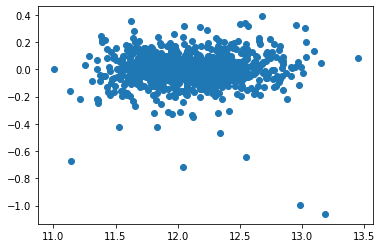

In [118]:
plt.scatter(y_, residuals);

In [119]:
(residuals).mean()

1.4570712505904736e-15

> Residuals are normally distributed

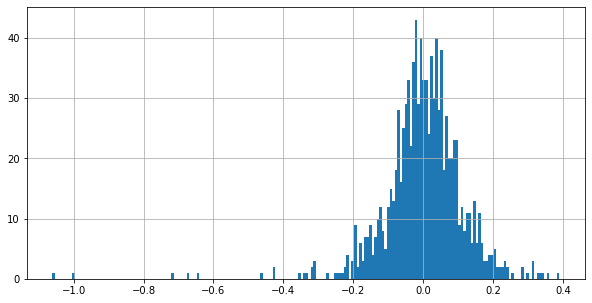

In [120]:
residuals.hist(bins = 200, figsize = (10, 5));

# Basis expansion

In [121]:
from sklearn.preprocessing import PolynomialFeatures

PF = PolynomialFeatures(degree=2)
xP = PF.fit_transform(xTrain2)
xTP = PF.transform(xTest2)

In [122]:
PR = LinearRegression()
PR.fit(xP, yTrain2)

LinearRegression()

In [123]:
PR.score(xP, yTrain2)

0.9640833559924858

## Model over fitted the training data with higher degree of th polynomial

In [124]:
PR.score(xTP, yTest2)

-4.524190213405689e+16

In [125]:
pD = np.c_[xP, yTrain2]

In [126]:
pGD = GradientDescent(data=pD, alpha=.01)

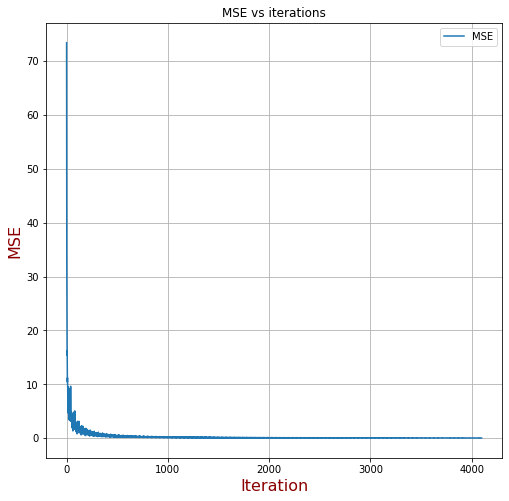

r2_score:  0.7360582064353169
Optimizer:  Mini Batch GD
Batch size:  25
Total number of iterations:  4100
alpha:  0.01
Optimal thetas values:
 [[ 3.97343755e+00]
 [ 3.97343755e+00]
 [ 3.35062943e-01]
 [ 6.65429835e-01]
 [ 2.77040048e-01]
 [ 3.31713079e-01]
 [ 8.17687354e-01]
 [ 4.98499304e-01]
 [ 1.29787274e+00]
 [ 9.65048786e-01]
 [ 4.11446063e-01]
 [ 4.25341364e-01]
 [ 9.94095412e-01]
 [ 9.75655342e-01]
 [ 5.80561735e-01]
 [ 7.34156507e-01]
 [ 9.33365274e-01]
 [ 8.50391234e-01]
 [ 1.29609090e-01]
 [-2.16945172e-02]
 [ 3.06475673e-03]
 [ 8.45782213e-02]
 [ 2.32597746e-01]
 [ 1.26926842e-01]
 [ 3.09267917e-02]
 [ 1.22904850e-01]
 [ 1.70044957e-01]
 [ 1.77653707e-01]
 [ 1.62189999e-02]
 [ 8.72960501e-03]
 [ 1.02917857e-02]
 [ 2.21245744e-01]
 [ 7.25921573e-03]
 [ 1.01514686e-02]
 [ 9.81169903e-02]
 [-6.65619465e-02]
 [ 3.21961588e-03]
 [-1.36840981e-02]
 [-2.68860727e-02]
 [-6.08493604e-02]
 [ 1.76407502e-02]
 [-1.53928635e-01]
 [-2.07697509e-03]
 [-8.17702481e-02]
 [-9.02082663e-02]
 [

In [127]:
pGD.fit(size=25, epochs=100)

In [128]:
theta_test_poly = pGD.steps[-1]['theta']
xTest_poly = np.c_[np.ones((xTP.shape[0], 1)), xTP]
y_test_poly = xTest_poly @ theta_test_poly

In [129]:
EvaluateModel(xTP, yTest2, y_test_poly.ravel())

The mean squared error is:  0.06502493693952759
the root mean squard error is:  0.2549998763519849
The mean absolute error is:  0.1945961324163044
The mean absolute perentage error is:  1.6360496862775464
The relative absolute error is:  0.6222849101827237
The coefficient of determination is:  0.6110255130967805
The adjusted coefficient of determination is:  1.366093634732442


# Support Vector Regressor

In [130]:
from sklearn.svm import SVR

## Testing MinMaxScaling vs StandardScaler

In [131]:
mmScaler = MinMaxScaler()
mmScaler = mmScaler.fit(train_data_x)
mm_xTrain = mmScaler.transform(train_data_x)
mm_xTest = mmScaler.transform(test_data_x)

In [132]:
mm_svr = SVR(C=100, kernel='rbf')
mm_svr.fit(mm_xTrain, yTrain)

SVR(C=100)

In [133]:
print("MinMax scaled data Train Score: ", mm_svr.score(mm_xTrain, yTrain))
print("MinMax scaled data Test Score: ", mm_svr.score(mm_xTest, yTest))

MinMax scaled data Train Score:  0.9604684707489755
MinMax scaled data Test Score:  0.8606591991026069


In [134]:
EvaluateModel(mm_xTest, yTest, mm_svr.predict(mm_xTest))

The mean squared error is:  0.023293627465367995
the root mean squard error is:  0.1526224998660682
The mean absolute error is:  0.10910260006414679
The mean absolute perentage error is:  0.9150121102554165
The relative absolute error is:  0.34889132090443736
The coefficient of determination is:  0.8606591991026069
The adjusted coefficient of determination is:  0.7490020010325105


In [135]:
stdScaler = StandardScaler()
stdScaler = stdScaler.fit(train_data_x)
std_xTrain = stdScaler.transform(train_data_x)
std_xTest = stdScaler.transform(test_data_x)

In [136]:
std_svr = SVR(C=100, kernel='rbf')
std_svr.fit(std_xTrain, yTrain)

SVR(C=100)

In [137]:
print("Standard scaled data Train Score: ", std_svr.score(std_xTrain, yTrain))
print("Standard scaled data Test Score: ", std_svr.score(std_xTest, yTest))

Standard scaled data Train Score:  0.9600776171446979
Standard scaled data Test Score:  0.7727661903637917


In [138]:
EvaluateModel(std_xTest, yTest, std_svr.predict(std_xTest))

The mean squared error is:  0.037986717997264004
the root mean squard error is:  0.19490181630057737
The mean absolute error is:  0.12569153343610817
The mean absolute perentage error is:  1.0542847267270135
The relative absolute error is:  0.401939872205107
The coefficient of determination is:  0.7727661903637917
The adjusted coefficient of determination is:  0.5906781707215321


## Standard scaled data gives better results on training but minmax gives better results on test data so i will be using MinMaxScaled data.

### Linear Kernal

In [139]:
C = [.01, .1, 1, 10, 20, 30, 33, 36, 40, 50, 100]
C_results = {}
for c in C:
    svm = SVR(kernel='linear', C=c)
    svm.fit(mm_xTrain, yTrain)
    y_ = svm.predict(mm_xTest)
    r_squared = svm.score(mm_xTest, yTest)
    adj_r2 = 1 - (((1-r_squared) * (len(mm_xTest)-1 ))/(len(mm_xTest) - mm_xTest.shape[1] -1 ))
    C_results[c] = adj_r2

In [140]:
C_results

{0.01: 0.7787397989272643,
 0.1: 0.8151968373047459,
 1: 0.817154922704786,
 10: 0.8160431055220398,
 20: 0.8158410881262023,
 30: 0.8174751908078404,
 33: 0.8168166789025777,
 36: 0.8155225052712055,
 40: 0.8173929386609768,
 50: 0.8170950427214764,
 100: 0.8162551898342834}

In [141]:
best_C = max(C_results, key=lambda x: C_results[x])
print("Best Value for C is: ", best_C)

Best Value for C is:  30


### Polynomial Kernel

In [142]:
degrees = [2, 3, 4, 5, 6, 7, 8, 9, 10]
poly_results = {}
for d in degrees:
    svm = SVR(kernel='poly', degree=d)
    svm.fit(mm_xTrain, yTrain)
    y_ = svm.predict(mm_xTest)
    r_squared = svm.score(mm_xTest, yTest)
    adj_r2 = 1 - (((1-r_squared) * (len(mm_xTest)-1 ))/(len(mm_xTest) - mm_xTest.shape[1] -1 ))
    poly_results[d] = adj_r2

In [143]:
poly_results

{2: 0.7874933900812777,
 3: 0.7767413382917134,
 4: 0.7547322945612248,
 5: 0.713784301684385,
 6: 0.6416471233449303,
 7: 0.5278260963812347,
 8: 0.3544568997325488,
 9: 0.11616100891009862,
 10: -0.19128107399414285}

In [144]:
best_degree = max(poly_results, key=lambda x: poly_results[x])
print("Best Value for polynomial degree is: ", best_degree)

Best Value for polynomial degree is:  2


In [145]:
C = [.01, .1, 1, 10, 30, 40, 50, 100, 1000]
poly_C_results = {}
for c in C:
    svm = SVR(kernel='poly', degree=2, C=c)
    svm.fit(mm_xTrain, yTrain)
    y_ = svm.predict(mm_xTest)
    r_squared = svm.score(mm_xTest, yTest)
    adj_r2 = 1 - (((1-r_squared) * (len(mm_xTest)-1 ))/(len(mm_xTest) - mm_xTest.shape[1] -1 ))
    poly_C_results[c] = adj_r2

In [146]:
poly_C_results

{0.01: 0.6248081783311044,
 0.1: 0.791671863794982,
 1: 0.7874933900812777,
 10: 0.7385140780610315,
 30: 0.7358127915574071,
 40: 0.7358127915574071,
 50: 0.7358127915574071,
 100: 0.7358127915574071,
 1000: 0.7358127915574071}

In [147]:
best_poly_C = max(poly_C_results, key=lambda x: poly_C_results[x])
print("Best Value for polynomial degree is: ", best_poly_C)

Best Value for polynomial degree is:  0.1


In [148]:
gamma = [.001, .01, .1, .2, .3, .4, .5, 1, 10, 20, 30, 100]
gamma_results = {}
for g in gamma:
    svm = SVR(kernel='poly', degree=2, gamma=g)
    svm.fit(mm_xTrain, yTrain)
    y_ = svm.predict(mm_xTest)
    r_squared = svm.score(mm_xTest, yTest)
    adj_r2 = 1 - (((1-r_squared) * (len(mm_xTest)-1 ))/(len(mm_xTest) - mm_xTest.shape[1] -1 ))
    gamma_results[g] = adj_r2

In [149]:
gamma_results

{0.001: -0.6325729460131166,
 0.01: 0.7102106470940444,
 0.1: 0.776180847974663,
 0.2: 0.7462761896223331,
 0.3: 0.7358668038524998,
 0.4: 0.7358216706492817,
 0.5: 0.7357791070427546,
 1: 0.7357791070427546,
 10: 0.7358352501331688,
 20: 0.7358352501331688,
 30: 0.7358366190264842,
 100: 0.7358557259210329}

In [150]:
best_gamma = max(gamma_results, key=lambda x: gamma_results[x])
print("Best Value for gamma is: ", best_gamma)

Best Value for gamma is:  0.1


In [151]:
coef0 = [.1, 1, 10, 15, 20, 30, 40, 50, 100]
coef0_results = {}
for c in coef0:
    svm = SVR(kernel='poly', degree=2, gamma=.1, coef0=c)
    svm.fit(mm_xTrain, yTrain)
    y_ = svm.predict(mm_xTest)
    r_squared = svm.score(mm_xTest, yTest)
    adj_r2 = 1 - (((1-r_squared) * (len(mm_xTest)-1 ))/(len(mm_xTest) - mm_xTest.shape[1] -1 ))
    coef0_results[c] = adj_r2

In [152]:
coef0_results

{0.1: 0.7767717393755238,
 1: 0.77794853562345,
 10: 0.7794399153172964,
 15: 0.7796659915758016,
 20: 0.779710015899607,
 30: 0.7797863044377329,
 40: 0.779701273466259,
 50: 0.7796379769270481,
 100: 0.7796374140852718}

In [153]:
best_coef = max(coef0_results, key=lambda x: coef0_results[x])
print("Best Value for coef0 is: ", best_coef)

Best Value for coef0 is:  30


### RBF Kernel

In [154]:
C = [.01, .1, 1, 10, 20, 30, 33, 36, 40, 50, 100]
rbf_C_results = {}
for c in C:
    svm = SVR(kernel='rbf', C=c)
    svm.fit(mm_xTrain, yTrain)
    y_ = svm.predict(mm_xTest)
    r_squared = svm.score(mm_xTest, yTest)
    adj_r2 = 1 - (((1-r_squared) * (len(mm_xTest)-1 ))/(len(mm_xTest) - mm_xTest.shape[1] -1 ))
    rbf_C_results[c] = adj_r2

In [155]:
rbf_C_results

{0.01: 0.24375993947428787,
 0.1: 0.7071056596110139,
 1: 0.761342769022036,
 10: 0.7490020010325105,
 20: 0.7490020010325105,
 30: 0.7490020010325105,
 33: 0.7490020010325105,
 36: 0.7490020010325105,
 40: 0.7490020010325105,
 50: 0.7490020010325105,
 100: 0.7490020010325105}

In [156]:
best_C_rbf = max(rbf_C_results, key=lambda x: rbf_C_results[x])
print("Best Value for coef0 is: ", best_C_rbf)

Best Value for coef0 is:  1


In [157]:
gamma = [.001, .01, .1, .2, .3, .4, .5, 1, 10, 20, 30, 100]
rbf_gamma_results = {}
for g in gamma:
    svm = SVR(kernel='poly', degree=2, gamma=g)
    svm.fit(mm_xTrain, yTrain)
    y_ = svm.predict(mm_xTest)
    r_squared = svm.score(mm_xTest, yTest)
    adj_r2 = 1 - (((1-r_squared) * (len(mm_xTest)-1 ))/(len(mm_xTest) - mm_xTest.shape[1] -1 ))
    rbf_gamma_results[g] = adj_r2

In [158]:
rbf_gamma_results

{0.001: -0.6325729460131166,
 0.01: 0.7102106470940444,
 0.1: 0.776180847974663,
 0.2: 0.7462761896223331,
 0.3: 0.7358668038524998,
 0.4: 0.7358216706492817,
 0.5: 0.7357791070427546,
 1: 0.7357791070427546,
 10: 0.7358352501331688,
 20: 0.7358352501331688,
 30: 0.7358366190264842,
 100: 0.7358557259210329}

In [159]:
rbf_best_gamma = max(rbf_gamma_results, key=lambda x: rbf_gamma_results[x])
print("Best Value for gamma is: ", rbf_best_gamma)

Best Value for gamma is:  0.1


## The best result came from linear kernel so i will test epsilon values on it

In [160]:
eps = [.1, .12, .13, .14, .2, .3, .4, .5, .6, .7]
eps_results = {}
for e in eps:
    svm = SVR(kernel='linear', C=30, epsilon=e)
    svm.fit(mm_xTrain, yTrain)
    y_ = svm.predict(mm_xTest)
    r_squared = svm.score(mm_xTest, yTest)
    adj_r2 = 1 - (((1-r_squared) * (len(mm_xTest)-1 ))/(len(mm_xTest) - mm_xTest.shape[1] -1 ))
    eps_results[e] = adj_r2

In [161]:
eps_results

{0.1: 0.8174751908078404,
 0.12: 0.8186425263175351,
 0.13: 0.8113616526493761,
 0.14: 0.8078587511560988,
 0.2: 0.7432333797467449,
 0.3: 0.6067526456363046,
 0.4: 0.5657429124210672,
 0.5: 0.5925015216976748,
 0.6: 0.5417796568274134,
 0.7: 0.48141149829162844}

In [162]:
best_eps = max(eps_results, key=lambda x: eps_results[x])
print("Best Value for gamma is: ", best_eps)

Best Value for gamma is:  0.12


# Testing Model resources usage

In [163]:
test_PF = PolynomialFeatures(degree=50)
xTrain_PF = PF.fit_transform(mm_xTrain)
xTest_PF = PF.transform(mm_xTest)

test_PR = LinearRegression()
test_PR.fit(xTrain_PF, yTrain)

LinearRegression()

In [165]:
xTrain_PF.shape

(1007, 7503)

In [164]:
test_svr = SVR(kernel='poly', degree=50)
test_svr.fit(mm_xTrain, yTrain)

SVR(degree=50, kernel='poly')

i don't know how to see memory consumption of each model but considering that polynomial regression make explicit expansion to the features
it will be using tons of memory to fit new features on the other hand SVR uses kernel to implicit calculate the similarty in higher dimension so it doesn't conume extra memory
for storing new calculation.
also time wise kernel uses much less time in my case polynomial took 4 sec to transform and fit the model, SVR nearly took no time at all